# Investor Behavior During Different Interest Rate Environments

#### Analysis uses two assets (stocks and bonds), the market rate on the 3-Month Treasury Bill as a proxy for the short-term risk-free rate, 10-Year Treasury yields, and the Federal Funds Effective Rate.

### Returns CRSP calculated as net returns:
$$r(t) = \frac{p(t)f(t) + d(t)}{p(t')} - 1$$
### where t' is a calendar date before t, typically period before but up to 10 if missing data

#### Variables are aggregated for i = m (monthly), d (daily):
1.  sp500_index_pct_return_i
    - S&P500 Stock Index Value-Weighted Return Including Dividends - Source: CRSP and expressed as "raw return" (not converted to percen)
2.  ice_bond_pct_return_i
    - ICE BofA US Corporate Index Total Return Index Value (Not Seasonally Adjusted) - Source: FRED (expressed as raw return)
3.  tr_3m_i
    - 3-Month Treasury Bill Secondary Market Rate, Discount Basis, Percent, Not Seasonally Adjusted (DTB3) - Source: FRED (expressed as percentage point and calculated based on a 360-day year; see https://www.federalreserve.gov/releases/h15/)
4.  tr_10y_i
    - Market Yield on 10-Year Treasury (Not Seasonally Adjusted) - Source: FRED (expressed as percentage point)
5.  ffer_i
    - Federal Funds Effective Rate (Not Seasonally Adjusted) - Source: FRED (expressed as percentage point)

#### Note: Data does not include market holidays or non-trading dates.

---

In [40]:
# ==============================================================================
# IMPORT COMPUTATIONAL, PLOTTING, STATISTICAL PACKAGES
# ==============================================================================

# Import necessary computational and plotting packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import openpyxl

# Import necessary statistical modeling and testing packages
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from arch import arch_model
from scipy.stats import skew, kurtosis, f, chi2, jarque_bera, norm
from scipy.optimize import minimize, differential_evolution
from scipy.optimize import Bounds
from scipy.integrate import quad # Used for numerical integration
from scipy.stats import t as student_t
from statsmodels.stats.stattools import jarque_bera
import tabulate
from scipy.stats import mannwhitneyu

## Data Extraction

### Daily Data Extraction

In [41]:
# ==============================================================================
# HISTORICAL FINANCIAL DATA - DAILY
# ==============================================================================

# pull data
path = '/Users/camerontaheri/python/investor_behavior/data/'
file = f"{path}fin_series_daily.xlsx"
df_raw_daily = pd.read_excel(file, engine="openpyxl")

# use date as the DateTime Index and set this as the DataFrame's Index instead of its typical integer index (index label: 'date')
df_raw_daily['date'] = pd.to_datetime(df_raw_daily['date'])
df_raw_daily.set_index('date', inplace = True)

# dataset information
print(df_raw_daily.shape)            # returns (rows, columns)
display(df_raw_daily.head())         # checking import is successful
display(df_raw_daily.tail())         # checking import is successful

(6541, 5)


,sp500_index_pct_return_d,ice_bond_pct_return_d,tr_10y_d,tr_3m_d,ffer_d
date,,,,,
1999-01-04,-0.000831,0.000000,4.69,4.38,5.04
1999-01-05,0.011888,-0.003838,4.74,4.37,4.54
1999-01-06,0.021143,0.002391,4.73,4.36,4.23
1999-01-07,-0.000799,-0.002691,4.77,4.33,4.49
1999-01-08,0.004604,-0.002579,4.86,4.37,4.74


,sp500_index_pct_return_d,ice_bond_pct_return_d,tr_10y_d,tr_3m_d,ffer_d
date,,,,,
2024-12-24,0.010566,0.001102,4.59,4.28,4.33
2024-12-26,0.000346,0.000000,4.58,4.24,4.33
2024-12-27,-0.010692,-0.002134,4.62,4.19,4.33
2024-12-30,-0.009878,0.004189,4.55,4.23,4.33
2024-12-31,-0.003392,-0.001767,4.58,4.23,4.33


#### Daily Timeframe: January 04, 1999 to December 31, 2024

### Monthly Data Extraction

In [42]:
# ==============================================================================
# HISTORICAL FINANCIAL DATA - MONTHLY
# ==============================================================================

# pull data
file = f"{path}fin_series_mthly.xlsx"
df_raw_monthly = pd.read_excel(file, engine="openpyxl")

# use date as the DateTime Index and set this as the DataFrame's Index instead of its typical integer index
df_raw_monthly['date'] = pd.to_datetime(df_raw_monthly['date'])
df_raw_monthly.set_index('date', inplace = True)

# show a few lines to check import is successful
print(df_raw_monthly.shape)
display(df_raw_monthly.head())
display(df_raw_monthly.tail())

(312, 5)


,sp500_index_pct_return_m,ice_bond_pct_return_m,tr_10y,tr_3m,ffer_m
date,,,,,
1999-01-29,0.038447,0.010215,4.72,4.34,4.79
1999-02-26,-0.038083,-0.025605,5.00,4.44,4.84
1999-03-31,0.037925,0.009089,5.23,4.44,4.98
1999-04-30,0.049092,0.003474,5.18,4.29,5.03
1999-05-28,-0.020708,-0.014470,5.54,4.50,4.61


,sp500_index_pct_return_m,ice_bond_pct_return_m,tr_10y,tr_3m,ffer_m
date,,,,,
2024-08-30,0.021572,0.015323,3.87,5.05,5.33
2024-09-30,0.020969,0.017230,3.72,4.72,4.83
2024-10-31,-0.008298,-0.022496,4.10,4.51,4.83
2024-11-29,0.064855,0.011958,4.36,4.42,4.58
2024-12-31,-0.031582,-0.017760,4.39,4.27,4.33


#### Monthly Timeframe: January 29, 1999 to December 31, 2024

---

## Data Cleaning

### Daily Data Cleaning

In [43]:
# ==============================================================================
# 1. CHECK FOR MISSING VALUES IN DAILY INDEX RETURNS (SP500 + ICE BOND)
# ==============================================================================

# define new DataFrame to hold any new calculated variables
df_clean_daily = df_raw_daily.copy()

# any exact 0.0 in the two return columns is due to holidays
pct_cols = ['sp500_index_pct_return_d', 'ice_bond_pct_return_d', 'tr_3m_d']

# *** BONDS ***
# take out -1 values from ICE Bond Index (note this is not an issue for the raw monthly data)
# this is from inherent missing values from the bond index level, where raw returns were calculated as L2/L1-1 L2 is today level and L1 is yesterday level
bond_col = pct_cols[1]
error_bond_mask = df_clean_daily[bond_col] <= -1
df_clean_daily[bond_col] = df_clean_daily[bond_col].mask(error_bond_mask, other=np.nan)
# **************

# treat anything numerically equal to zero as missing
zero_mask = np.isclose(df_clean_daily[pct_cols], 0.0)
df_clean_daily[pct_cols] = df_clean_daily[pct_cols].mask(zero_mask, other=np.nan)

# drop days where either market didn't trade (when percent returns are NaN values)
df_clean_daily.dropna(subset=pct_cols, inplace=True)   # <- no re-assignment here

# check if the maximum absolute return value is less than 0.1 for logging purposes
max_abs_ret1 = df_clean_daily['sp500_index_pct_return_d'].abs().max()
check = max_abs_ret1 < 0.1
print(check)
print(max_abs_ret1)

max_abs_ret2 = df_clean_daily['ice_bond_pct_return_d'].abs().max()
check = max_abs_ret2 < 0.1
print(check)
print(max_abs_ret2)

max_abs_ret2 = df_clean_daily['tr_3m_d'].abs().max()
check = max_abs_ret2 < 10
print(check)
print(max_abs_ret2)

display(df_clean_daily)

False
0.11816767607044774
True
0.03757542158733429
True
6.24


,sp500_index_pct_return_d,ice_bond_pct_return_d,tr_10y_d,tr_3m_d,ffer_d
date,,,,,
1999-01-05,0.011888,-0.003838,4.74,4.37,4.54
1999-01-06,0.021143,0.002391,4.73,4.36,4.23
1999-01-07,-0.000799,-0.002691,4.77,4.33,4.49
1999-01-08,0.004604,-0.002579,4.86,4.37,4.74
1999-01-11,-0.004982,-0.001506,4.90,4.39,5.17
...,...,...,...,...,...
2024-12-23,0.005633,-0.002805,4.59,4.24,4.33
2024-12-24,0.010566,0.001102,4.59,4.28,4.33
2024-12-27,-0.010692,-0.002134,4.62,4.19,4.33


#### Although the max absolute returns for the S&P 500 is not below 0.1, it is still within a reasonable distance and logged returns will be used for their statistical advantages.

### Monthly Data Cleaning

In [44]:
# ==============================================================================
# 2. CHECK FOR MISSING VALUES IN MONTHLY INDEX RETURNS (SP500 + ICE BOND)
# ==============================================================================

# define new DataFrame to hold any new calculated variables
df_clean_monthly = df_raw_monthly.copy()

# any exact 0.0 in the two return columns is due to holidays
pct_cols = ['sp500_index_pct_return_m', 'ice_bond_pct_return_m', 'tr_3m']

# *** BONDS ***
# take out -1 values from ICE Bond Index (note this is not an issue for the raw monthly data)
# this is from inherent missing values from the bond index level, where raw returns were calculated as L2/L1-1 L2 is today level and L1 is yesterday level
bond_col = pct_cols[1]
error_bond_mask = df_clean_monthly[bond_col] <= -1
df_clean_monthly[bond_col] = df_clean_monthly[bond_col].mask(error_bond_mask, other=np.nan)
# **************

# treat anything numerically equal to zero as missing
zero_mask = np.isclose(df_clean_monthly[pct_cols], 0.0)
df_clean_monthly[pct_cols] = df_clean_monthly[pct_cols].mask(zero_mask, other=np.nan)

# drop days where either market didn't trade (when percent returns are NaN values)
df_clean_monthly.dropna(subset=pct_cols, inplace=True)   # <- no re-assignment here

# check if the maximum absolute return value is less than 0.1 for logging purposes
max_abs_ret1 = df_clean_monthly['sp500_index_pct_return_m'].abs().max()
check = max_abs_ret1 < 0.1
print(check)
print(max_abs_ret1)

max_abs_ret2 = df_clean_monthly['ice_bond_pct_return_m'].abs().max()
check = max_abs_ret2 < 0.1
print(check)
print(max_abs_ret2)

max_abs_ret2 = df_clean_monthly['tr_3m'].abs().max()
check = max_abs_ret2 < 10
print(check)
print(max_abs_ret2)

display(df_clean_monthly)

False
0.18483329999999998
True
0.07474036323917443
True
6.17


,sp500_index_pct_return_m,ice_bond_pct_return_m,tr_10y,tr_3m,ffer_m
date,,,,,
1999-01-29,0.038447,0.010215,4.72,4.34,4.79
1999-02-26,-0.038083,-0.025605,5.00,4.44,4.84
1999-03-31,0.037925,0.009089,5.23,4.44,4.98
1999-04-30,0.049092,0.003474,5.18,4.29,5.03
1999-05-28,-0.020708,-0.014470,5.54,4.50,4.61
...,...,...,...,...,...
2024-08-30,0.021572,0.015323,3.87,5.05,5.33
2024-09-30,0.020969,0.017230,3.72,4.72,4.83
2024-10-31,-0.008298,-0.022496,4.10,4.51,4.83


#### Similar to daily returns for the S&P500, monthly returns are within a reasonable distance and logged returns will still be used for their statistical advantages.

### Logged Excess Returns

In [45]:
# ==============================================================================
# 3. CALCULATE DAILY LOGGED EXCESS RETURNS
# ==============================================================================

# create log RF rate scaled (Board of Governors' annualize 3MTB at 360 days)
df_log_RF_daily = pd.DataFrame(np.log1p((df_clean_daily['tr_3m_d'] / (100 * 360)))).dropna()
df_log_RF_daily = df_log_RF_daily.rename(columns={'tr_3m_d': 'log_3MTB_d'})

# create log asset returns
asset_cols = ['sp500_index_pct_return_d', 'ice_bond_pct_return_d']
df_log_assets_daily = pd.DataFrame(np.log1p(df_clean_daily[asset_cols])).dropna()
df_log_assets_daily = df_log_assets_daily.rename(columns={
    'sp500_index_pct_return_d':'log_stock_ret_d', 
    'ice_bond_pct_return_d': 'log_bond_ret_d'
    })

# merge the three logged variables (RF, stocks, bonds)
df_logged_daily = pd.merge(left=df_log_RF_daily, right=df_log_assets_daily, how='inner', on='date')
display(df_logged_daily)

print("--- Computing Excess Returns ---")
df_logged_daily['log_stock_excess_d'] = df_logged_daily['log_stock_ret_d'] - df_logged_daily['log_3MTB_d']
df_logged_daily['log_bond_excess_d'] = df_logged_daily['log_bond_ret_d'] - df_logged_daily['log_3MTB_d']

# diagnostics
print("NaNs remaining:\n", df_logged_daily.isna().sum())
print("\ninf remaining:\n", np.isinf(df_logged_daily).sum())
display(df_logged_daily)

,log_3MTB_d,log_stock_ret_d,log_bond_ret_d
date,,,
1999-01-05,0.000121,0.011818,-0.003846
1999-01-06,0.000121,0.020922,0.002388
1999-01-07,0.000120,-0.000800,-0.002694
1999-01-08,0.000121,0.004593,-0.002583
1999-01-11,0.000122,-0.004994,-0.001507
...,...,...,...
2024-12-23,0.000118,0.005617,-0.002809
2024-12-24,0.000119,0.010510,0.001102
2024-12-27,0.000116,-0.010749,-0.002136


--- Computing Excess Returns ---
NaNs remaining:
 log_3MTB_d            0
log_stock_ret_d       0
log_bond_ret_d        0
log_stock_excess_d    0
log_bond_excess_d     0
dtype: int64

inf remaining:
 log_3MTB_d            0
log_stock_ret_d       0
log_bond_ret_d        0
log_stock_excess_d    0
log_bond_excess_d     0
dtype: int64


,log_3MTB_d,log_stock_ret_d,log_bond_ret_d,log_stock_excess_d,log_bond_excess_d
date,,,,,
1999-01-05,0.000121,0.011818,-0.003846,0.011696,-0.003967
1999-01-06,0.000121,0.020922,0.002388,0.020801,0.002267
1999-01-07,0.000120,-0.000800,-0.002694,-0.000920,-0.002815
1999-01-08,0.000121,0.004593,-0.002583,0.004472,-0.002704
1999-01-11,0.000122,-0.004994,-0.001507,-0.005116,-0.001629
...,...,...,...,...,...
2024-12-23,0.000118,0.005617,-0.002809,0.005499,-0.002927
2024-12-24,0.000119,0.010510,0.001102,0.010391,0.000983
2024-12-27,0.000116,-0.010749,-0.002136,-0.010866,-0.002252


In [46]:
# ==============================================================================
# 4. CALCULATE MONTHLY LOGGED EXCESS RETURNS
# ==============================================================================

# create log RF rate scaled (Board of Governors' annualize 3MTB at 12 months)
df_log_RF_monthly = pd.DataFrame(np.log1p((df_clean_monthly['tr_3m'] / (100 * 12)))).dropna()
df_log_RF_monthly = df_log_RF_monthly.rename(columns={'tr_3m': 'log_3MTB_m'})

# create log asset returns
asset_cols = ['sp500_index_pct_return_m', 'ice_bond_pct_return_m']
df_log_assets_monthly = pd.DataFrame(np.log1p(df_clean_monthly[asset_cols])).dropna()
df_log_assets_monthly = df_log_assets_monthly.rename(columns={
    'sp500_index_pct_return_m':'log_stock_ret_m', 
    'ice_bond_pct_return_m': 'log_bond_ret_m'
    })

# merge the three logged variables (RF, stocks, bonds)
df_logged_monthly = pd.merge(left=df_log_RF_monthly, right=df_log_assets_monthly, how='inner', on='date')
display(df_logged_monthly)

print("--- Computing Excess Returns ---")
df_logged_monthly['log_stock_excess_m'] = df_logged_monthly['log_stock_ret_m'] - df_logged_monthly['log_3MTB_m']
df_logged_monthly['log_bond_excess_m'] = df_logged_monthly['log_bond_ret_m'] - df_logged_monthly['log_3MTB_m']

# diagnostics
print("NaNs remaining:\n", df_logged_monthly.isna().sum())
print("\ninf remaining:\n", np.isinf(df_logged_monthly).sum())
display(df_logged_monthly)

,log_3MTB_m,log_stock_ret_m,log_bond_ret_m
date,,,
1999-01-29,0.003610,0.037726,0.010163
1999-02-26,0.003693,-0.038827,-0.025938
1999-03-31,0.003693,0.037224,0.009048
1999-04-30,0.003569,0.047925,0.003468
1999-05-28,0.003743,-0.020925,-0.014575
...,...,...,...
2024-08-30,0.004200,0.021343,0.015206
2024-09-30,0.003926,0.020753,0.017083
2024-10-31,0.003751,-0.008333,-0.022753


--- Computing Excess Returns ---
NaNs remaining:
 log_3MTB_m            0
log_stock_ret_m       0
log_bond_ret_m        0
log_stock_excess_m    0
log_bond_excess_m     0
dtype: int64

inf remaining:
 log_3MTB_m            0
log_stock_ret_m       0
log_bond_ret_m        0
log_stock_excess_m    0
log_bond_excess_m     0
dtype: int64


,log_3MTB_m,log_stock_ret_m,log_bond_ret_m,log_stock_excess_m,log_bond_excess_m
date,,,,,
1999-01-29,0.003610,0.037726,0.010163,0.034116,0.006553
1999-02-26,0.003693,-0.038827,-0.025938,-0.042520,-0.029631
1999-03-31,0.003693,0.037224,0.009048,0.033531,0.005355
1999-04-30,0.003569,0.047925,0.003468,0.044356,-0.000101
1999-05-28,0.003743,-0.020925,-0.014575,-0.024668,-0.018318
...,...,...,...,...,...
2024-08-30,0.004200,0.021343,0.015206,0.017143,0.011007
2024-09-30,0.003926,0.020753,0.017083,0.016827,0.013157
2024-10-31,0.003751,-0.008333,-0.022753,-0.012084,-0.026504


In [47]:
# Consolidation of logged excess returns into their own DataFrame
df_logged_daily_copy = df_logged_daily.copy()
df_logged_monthly_copy = df_logged_monthly.copy()
df_log_excess_d = df_logged_daily_copy[['log_stock_excess_d', 'log_bond_excess_d']]
df_log_excess_m = df_logged_monthly[['log_stock_excess_m', 'log_bond_excess_m']]

display(df_log_excess_d)
display(df_log_excess_m)

,log_stock_excess_d,log_bond_excess_d
date,,
1999-01-05,0.011696,-0.003967
1999-01-06,0.020801,0.002267
1999-01-07,-0.000920,-0.002815
1999-01-08,0.004472,-0.002704
1999-01-11,-0.005116,-0.001629
...,...,...
2024-12-23,0.005499,-0.002927
2024-12-24,0.010391,0.000983
2024-12-27,-0.010866,-0.002252


,log_stock_excess_m,log_bond_excess_m
date,,
1999-01-29,0.034116,0.006553
1999-02-26,-0.042520,-0.029631
1999-03-31,0.033531,0.005355
1999-04-30,0.044356,-0.000101
1999-05-28,-0.024668,-0.018318
...,...,...
2024-08-30,0.017143,0.011007
2024-09-30,0.016827,0.013157
2024-10-31,-0.012084,-0.026504


### Simple Excess Returns

In [48]:
# ==============================================================================
# 5. CALCULATE DAILY EXCESS RETURNS
# ==============================================================================

# create RF rate scaled (Board of Governors' annualize 3MTB at 360 days; deannualize to decimals)
df_RF_daily = pd.DataFrame((df_clean_daily['tr_3m_d'] / (100 * 360))).dropna()
df_RF_daily = df_RF_daily.rename(columns={'tr_3m_d': '3MTB_d'})

# create asset returns (decimals)
asset_cols = ['sp500_index_pct_return_d', 'ice_bond_pct_return_d']
df_assets_daily = pd.DataFrame(df_clean_daily[asset_cols]).dropna()
df_assets_daily = df_assets_daily.rename(columns={
    'sp500_index_pct_return_d':'stock_ret_d', 
    'ice_bond_pct_return_d': 'bond_ret_d'
    })

# merge the three variables (RF, stocks, bonds)
df_daily = pd.merge(left=df_RF_daily, right=df_assets_daily, how='inner', on='date')
display(df_daily)

print("--- Computing Excess Returns ---")
df_daily['stock_excess_d'] = df_daily['stock_ret_d'] - df_daily['3MTB_d']
df_daily['bond_excess_d'] = df_daily['bond_ret_d'] - df_daily['3MTB_d']

# diagnostics
print("NaNs remaining:\n", df_daily.isna().sum())
print("\ninf remaining:\n", np.isinf(df_daily).sum())
display(df_daily)

,3MTB_d,stock_ret_d,bond_ret_d
date,,,
1999-01-05,0.000121,0.011888,-0.003838
1999-01-06,0.000121,0.021143,0.002391
1999-01-07,0.000120,-0.000799,-0.002691
1999-01-08,0.000121,0.004604,-0.002579
1999-01-11,0.000122,-0.004982,-0.001506
...,...,...,...
2024-12-23,0.000118,0.005633,-0.002805
2024-12-24,0.000119,0.010566,0.001102
2024-12-27,0.000116,-0.010692,-0.002134


--- Computing Excess Returns ---
NaNs remaining:
 3MTB_d            0
stock_ret_d       0
bond_ret_d        0
stock_excess_d    0
bond_excess_d     0
dtype: int64

inf remaining:
 3MTB_d            0
stock_ret_d       0
bond_ret_d        0
stock_excess_d    0
bond_excess_d     0
dtype: int64


,3MTB_d,stock_ret_d,bond_ret_d,stock_excess_d,bond_excess_d
date,,,,,
1999-01-05,0.000121,0.011888,-0.003838,0.011767,-0.003960
1999-01-06,0.000121,0.021143,0.002391,0.021022,0.002270
1999-01-07,0.000120,-0.000799,-0.002691,-0.000920,-0.002811
1999-01-08,0.000121,0.004604,-0.002579,0.004483,-0.002701
1999-01-11,0.000122,-0.004982,-0.001506,-0.005104,-0.001628
...,...,...,...,...,...
2024-12-23,0.000118,0.005633,-0.002805,0.005515,-0.002923
2024-12-24,0.000119,0.010566,0.001102,0.010447,0.000983
2024-12-27,0.000116,-0.010692,-0.002134,-0.010808,-0.002250


In [49]:
# ==============================================================================
# 6. CALCULATE MONTHLY EXCESS RETURNS
# ==============================================================================

# create RF rate scaled (Board of Governors' annualize 3MTB at 12 months; deannualize to decimals)
df_RF_monthly = pd.DataFrame((df_clean_monthly['tr_3m'] / (100 * 12))).dropna()
df_RF_monthly = df_RF_monthly.rename(columns={'tr_3m': '3MTB_m'})

# create asset returns (decimals)
asset_cols = ['sp500_index_pct_return_m', 'ice_bond_pct_return_m']
df_assets_monthly = pd.DataFrame(df_clean_monthly[asset_cols]).dropna()
df_assets_monthly = df_assets_monthly.rename(columns={
    'sp500_index_pct_return_m':'stock_ret_m', 
    'ice_bond_pct_return_m': 'bond_ret_m'
    })

# merge the three variables (RF, stocks, bonds)
df_monthly = pd.merge(left=df_RF_monthly, right=df_assets_monthly, how='inner', on='date')
display(df_monthly)

print("--- Computing Excess Returns ---")
df_monthly['stock_excess_m'] = df_monthly['stock_ret_m'] - df_monthly['3MTB_m']
df_monthly['bond_excess_m'] = df_monthly['bond_ret_m'] - df_monthly['3MTB_m']

# diagnostics
print("NaNs remaining:\n", df_monthly.isna().sum())
print("\ninf remaining:\n", np.isinf(df_monthly).sum())
display(df_monthly)

,3MTB_m,stock_ret_m,bond_ret_m
date,,,
1999-01-29,0.003617,0.038447,0.010215
1999-02-26,0.003700,-0.038083,-0.025605
1999-03-31,0.003700,0.037925,0.009089
1999-04-30,0.003575,0.049092,0.003474
1999-05-28,0.003750,-0.020708,-0.014470
...,...,...,...
2024-08-30,0.004208,0.021572,0.015323
2024-09-30,0.003933,0.020969,0.017230
2024-10-31,0.003758,-0.008298,-0.022496


--- Computing Excess Returns ---
NaNs remaining:
 3MTB_m            0
stock_ret_m       0
bond_ret_m        0
stock_excess_m    0
bond_excess_m     0
dtype: int64

inf remaining:
 3MTB_m            0
stock_ret_m       0
bond_ret_m        0
stock_excess_m    0
bond_excess_m     0
dtype: int64


,3MTB_m,stock_ret_m,bond_ret_m,stock_excess_m,bond_excess_m
date,,,,,
1999-01-29,0.003617,0.038447,0.010215,0.034830,0.006598
1999-02-26,0.003700,-0.038083,-0.025605,-0.041783,-0.029305
1999-03-31,0.003700,0.037925,0.009089,0.034225,0.005389
1999-04-30,0.003575,0.049092,0.003474,0.045517,-0.000101
1999-05-28,0.003750,-0.020708,-0.014470,-0.024458,-0.018220
...,...,...,...,...,...
2024-08-30,0.004208,0.021572,0.015323,0.017364,0.011114
2024-09-30,0.003933,0.020969,0.017230,0.017036,0.013296
2024-10-31,0.003758,-0.008298,-0.022496,-0.012057,-0.026254


In [50]:
# Consolidation of logged excess returns into their own DataFrame
df_excess_d = df_daily[['stock_excess_d', 'bond_excess_d']]
df_excess_m = df_monthly[['stock_excess_m', 'bond_excess_m']]

display(df_excess_d)
display(df_excess_m)

,stock_excess_d,bond_excess_d
date,,
1999-01-05,0.011767,-0.003960
1999-01-06,0.021022,0.002270
1999-01-07,-0.000920,-0.002811
1999-01-08,0.004483,-0.002701
1999-01-11,-0.005104,-0.001628
...,...,...
2024-12-23,0.005515,-0.002923
2024-12-24,0.010447,0.000983
2024-12-27,-0.010808,-0.002250


,stock_excess_m,bond_excess_m
date,,
1999-01-29,0.034830,0.006598
1999-02-26,-0.041783,-0.029305
1999-03-31,0.034225,0.005389
1999-04-30,0.045517,-0.000101
1999-05-28,-0.024458,-0.018220
...,...,...
2024-08-30,0.017364,0.011114
2024-09-30,0.017036,0.013296
2024-10-31,-0.012057,-0.026254


---

## Conditional Volatility

### Daily

In [51]:
# ==============================================================================
# CONDITIONAL VOLATILITY OF LOG DAILY EXCESS RETURNS
# ==============================================================================

# create a function for AR(1)-GARCH(1,1) Model
def fit_ar1garch11(series, dist_name):
    # fit AR(1)-GARCH(1,1) with chosen distribution; return result object.
    mod = arch_model(series,
                     mean="AR", lags=1,         # significant serial correlation of daily returns merits an AR(1) process
                     vol="Garch", p=1, q=1,     # significant serial correlation of squared daily returns merits GARCH(1,1) process
                     dist=dist_name)
    result = mod.fit(disp="off")
    return result

print("Conditional Volatility Estimation (AR(1)-GARCH(1,1))")
print("----------------------------------------------------")

# scale excess returns by 100 for GARCH
df_log_excess_d_scaled = df_log_excess_d * 100

for col in df_log_excess_d_scaled.columns:

    # fit both specifications
    result_norm = fit_ar1garch11(df_log_excess_d_scaled[col], "normal")
    result_t    = fit_ar1garch11(df_log_excess_d_scaled[col], "t")

    # choose the distribution for the standard errors that has a lower AIC
    best_result = result_norm if result_norm.aic < result_t.aic else result_t
    best_dist = "Normal" if best_result is result_norm else "Student-t"

    # store result for each asset
    if 'stock' in col:
        stock_result = best_result
    elif 'bond' in col:
        bond_result = best_result
    
    # display result
    print(f"\n{col}: best fit = {best_dist} (AIC = {best_result.aic:.2f})")
    print(best_result.summary())

# check that the variables are now correctly populated
if stock_result and bond_result:
    print("\nSuccessfully stored models.")

Conditional Volatility Estimation (AR(1)-GARCH(1,1))
----------------------------------------------------

log_stock_excess_d: best fit = Student-t (AIC = 17514.26)
                              AR - GARCH Model Results                              
Dep. Variable:           log_stock_excess_d   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -8751.13
Distribution:      Standardized Student's t   AIC:                           17514.3
Method:                  Maximum Likelihood   BIC:                           17554.8
                                              No. Observations:                 6400
Date:                      Tue, Jan 06 2026   Df Residuals:                     6398
Time:                              20:13:01   Df Model:                            2
                                    Mean Model                        

#### Coefficients for past shocks (${u_{t-1} ^2}$) and past conditional volatility (${h_{t-1}}$) are significant at the 5\% level for scaled log excess returns of stocks and bonds, suggesting past shocks persist into the future. Interestingly, all coefficients are statistically significant except the AR coefficient on bonds. The lagged conditional volatility variable (${h_{t-1}}$), here represented by beta, carries the largest magnitude in both series, implying past shocks not only persist but have a high degree of influence. This volatility clustering tends to diminish over the lower frequencies.

---

## DCC-GARCH Model

# Dynamic Conditional Correlation (DCC) GARCH(1,1) Model

The DCC model decomposes the conditional covariance matrix ($\mathbf{H}_t$) into conditional standard deviations ($\mathbf{D}_t$) and the conditional correlation matrix ($\mathbf{R}_t$).

$$\mathbf{H}_t = \mathbf{D}_t \mathbf{R}_t \mathbf{D}_t$$


### Stage 1: Conditional Variance ($\mathbf{D}_t$)

$\mathbf{D}_t$ is a $2 \times 2$ diagonal matrix containing the conditional standard deviations ($\sigma_{i,t}$) from your individual $\text{AR}(1)-\text{GARCH}(1,1)-t$ models.

$$\mathbf{D}_t = \begin{bmatrix} \sigma_{1, t} & 0 \\ 0 & \sigma_{2, t} \end{bmatrix}$$

Each variance ($\sigma^2_{i, t}$) is modeled using the GARCH(1,1) equation on the $\text{AR}(1)$ residuals ($u_{i, t}$):

$$\sigma^2_{i, t} = \omega_i + \alpha_i u^2_{i, t-1} + \beta_i \sigma^2_{i, t-1}$$

The **Standardized Residuals** ($\mathbf{z}_t$) used in Stage 2 are calculated as:

$$\mathbf{z}_t = \mathbf{D}_t^{-1} \mathbf{u}_t = \begin{bmatrix} z_{1, t} \\ z_{2, t} \end{bmatrix} \quad \text{where} \quad z_{i, t} = \frac{u_{i, t}}{\sigma_{i, t}}$$

In [52]:
# ==============================================================================
# Conditional Variance (Dt)
# ==============================================================================

# extract conditional standard deviations (Dt)
stock_std = stock_result.conditional_volatility.dropna()
bond_std = bond_result.conditional_volatility.dropna()

print(f"Stock conditional standard deviations from GARCH(1,1): \n{stock_std}")
print(f"Bond conditional standard deviations from GARCH(1,1): \n{bond_std}")

# extract standardized residuals (zt)
z1_t = stock_result.std_resid.dropna() # z1_t
z2_t = bond_result.std_resid.dropna() # z2_t

# align the series and create the Z_t matrix
Z_t = pd.DataFrame({'z1': z1_t, 'z2': z2_t}).dropna().values
T = Z_t.shape[0]

print(f"standardized residuals: \n{Z_t}")
print(f"\nNumber of Observations: {T}")

# conditional standard deviations for Dt (aligned with Z_t)
Dt_stock = stock_std.loc[z1_t.index].values
Dt_bond = bond_std.loc[z2_t.index].values

print(Dt_stock)
print(Dt_bond)

# unconditional correlation matrix will be the starting point for the DCC model, where R_bar = E[z_t * z_t']
R_bar = np.cov(Z_t.T) # This is a 2x2 matrix

print(f"\nR_bar-cov:\n{R_bar}")

Stock conditional standard deviations from GARCH(1,1): 
date
1999-01-06    1.263587
1999-01-07    1.378065
1999-01-08    1.297792
1999-01-11    1.228628
1999-01-12    1.174535
                ...   
2024-12-23    1.172783
2024-12-24    1.118882
2024-12-27    1.106738
2024-12-30    1.113844
2024-12-31    1.117849
Name: cond_vol, Length: 6400, dtype: float64
Bond conditional standard deviations from GARCH(1,1): 
date
1999-01-06    0.326030
1999-01-07    0.321008
1999-01-08    0.319948
1999-01-11    0.318580
1999-01-12    0.313168
                ...   
2024-12-23    0.371091
2024-12-24    0.367857
2024-12-27    0.358449
2024-12-30    0.353212
2024-12-31    0.354779
Name: cond_vol, Length: 6400, dtype: float64
standardized residuals: 
[[ 1.61019626  0.63152834]
 [-0.08007641 -0.92924153]
 [ 0.28053777 -0.90785947]
 ...
 [-1.02642101 -0.67763502]
 [-1.00300801  1.09456006]
 [-0.413167   -0.57572558]]

Number of Observations: 6400
[1.26358722 1.37806517 1.29779181 ... 1.10673818 1.11384407 

### Stage 2: Conditional Correlation ($\mathbf{R}_t$)

The conditional correlation matrix $\mathbf{R}_t$ is obtained by normalizing an intermediate covariance matrix $\mathbf{Q}_t$.

#### 1. Intermediate Covariance Matrix ($\mathbf{Q}_t$)

$\mathbf{Q}_t$ evolves with a GARCH-like dynamic structure governed by the estimated DCC parameters $a$ and $b$:

$$\mathbf{Q}_t = (1 - a - b) \overline{\mathbf{R}} + a(\mathbf{z}_{t-1}\mathbf{z}_{t-1}') + b\mathbf{Q}_{t-1}$$

Where $\overline{\mathbf{R}}$ is the **unconditional correlation** matrix of the standardized residuals $\mathbf{z}_t$.

#### 2. Normalization to Obtain $\mathbf{R}_t$

$\mathbf{R}_t$ is obtained by normalizing $\mathbf{Q}_t$ to ensure its diagonal elements (correlations) are exactly 1.

$$\mathbf{R}_t = \mathbf{Q}_t^{*} \mathbf{Q}_t \mathbf{Q}_t^{*}$$

Where $\mathbf{Q}_t^{*}$ is the diagonal matrix containing the inverse square roots of the diagonal elements of $\mathbf{Q}_t$:

$$\mathbf{Q}_t^{*} = [\text{diag}(\mathbf{Q}_t)]^{-1/2} = \begin{bmatrix} \frac{1}{\sqrt{\mathbf{Q}_{11, t}}} & 0 \\ 0 & \frac{1}{\sqrt{\mathbf{Q}_{22, t}}} \end{bmatrix}$$


### Optimization Target (Minimization)

The DCC parameters $a$ and $b$ are estimated by minimizing the negative log-likelihood function (the correlation part):

$$\text{Minimize} \quad \sum_{t=1}^{T} \left[ \log(|\mathbf{R}_t|) + \mathbf{z}_t' \mathbf{R}_t^{-1} \mathbf{z}_t \right]$$

In [53]:
# ==============================================================================
# define log-likelihood function for DCC governance parameters a,b
# ==============================================================================

def dcc_likelihood(params, Z_t, R_bar):
    # Calculates the negative log-likelihood for the DCC parameters a and b
    a, b = params
    T = Z_t.shape[0]
    
    # initialize Q_t at the unconditional mean (R_bar)
    Q_t = R_bar.copy()
    
    # initialize the sum of the log-likelihood function
    log_likelihood_sum = 0
    
    for t in range(T):
        z_t = Z_t[t, :].reshape(2, 1) # 2x1 vector
        z_t_outer = z_t @ z_t.T       # z_t * z_t' (2x2 matrix)
        
        # 1. Update Q_t (Qt = (1-a-b)R_bar + a*z_t-1*z_t-1' + b*Q_t-1)
        # Note: z_t_outer uses current t, so we model Q_t+1 or assume Q_t starts with t-1 data
        # For simplicity, we use the standard iterative approach where Q_t is the matrix
        # at time t, estimated from time t-1 data.
        if t > 0:
            Q_t = (1 - a - b) * R_bar + a * Z_t_outer_prev + b * Q_t_prev
        
        # 2. Normalize Q_t to get R_t (Rt = Q_t* Q_t Q_t*)
        Q_diag_sqrt_inv = np.diag(1 / np.sqrt(np.diag(Q_t)))
        R_t = Q_diag_sqrt_inv @ Q_t @ Q_diag_sqrt_inv
        
        # Ensure R_t is positive definite (critical for inverse)
        # Add a tiny amount to the diagonal if not
        if np.linalg.det(R_t) <= 0:
             R_t = R_t + 1e-6 * np.eye(2)
        
        # 3. Calculate log-likelihood contribution
        log_likelihood_sum += np.log(np.linalg.det(R_t)) + z_t.T @ np.linalg.inv(R_t) @ z_t
        
        # Store current values for next iteration
        Q_t_prev = Q_t
        Z_t_outer_prev = z_t_outer

    # Minimize the negative sum (we only include the correlation part)
    return 0.5 * log_likelihood_sum[0, 0]

# run log-likelihood

# initial guess for a and b (must satisfy a + b < 1)
initial_params = np.array([0.05, 0.90]) 

# Constraints: a > 0, b > 0, a + b < 1
bounds = [(0.0, 1.0), (0.0, 1.0)] 

# Run the optimization
print("\n--- STAGE 2: Optimizing DCC Correlation Parameters (a, b) ---")
dcc_fit = minimize(
    dcc_likelihood,
    initial_params,
    args=(Z_t, R_bar),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True, 'maxiter': 500}
)

# Extract optimized parameters
a_hat, b_hat = dcc_fit.x
print(f"\nOptimization Success: {dcc_fit.success}")
print(f"DCC Parameters: a_hat={a_hat:.6f}, b_hat={b_hat:.6f}, Sum={a_hat + b_hat:.6f}")


--- STAGE 2: Optimizing DCC Correlation Parameters (a, b) ---


/var/folders/gc/s0xv0zy917nfx03_ndbkjb6m0000gn/T/ipykernel_16590/3958581078.py:37: RuntimeWarning: invalid value encountered in log
  log_likelihood_sum += np.log(np.linalg.det(R_t)) + z_t.T @ np.linalg.inv(R_t) @ z_t
/var/folders/gc/s0xv0zy917nfx03_ndbkjb6m0000gn/T/ipykernel_16590/3958581078.py:28: RuntimeWarning: invalid value encountered in sqrt
  Q_diag_sqrt_inv = np.diag(1 / np.sqrt(np.diag(Q_t)))
/Users/camerontaheri/python/venv_finmet/lib/python3.13/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 6161.381808649826
            Iterations: 11
            Function evaluations: 39
            Gradient evaluations: 11

Optimization Success: True
DCC Parameters: a_hat=0.043513, b_hat=0.940863, Sum=0.984376


In [54]:
# ==============================================================================
# Construct Conditional Covariance Matrix Ht
# ==============================================================================

# Use the estimated parameters
a_hat, b_hat = dcc_fit.x
a = a_hat
b = b_hat
T = Z_t.shape[0]

def generate_conditional_covariance(a, b, Z_t, R_bar, Dt_stock, Dt_bond):
    # generates the time series of H_t matrices using optimized DCC parameters
    T = Z_t.shape[0]
    H_t_list = []
    
    Q_t_prev = R_bar.copy()
    Z_t_outer_prev = R_bar.copy() # initialized for the first iteration logic

    for t in range(T):
        
        # 1. Update Q_t
        if t > 0:
            Q_t = (1 - a - b) * R_bar + a * Z_t_outer_prev + b * Q_t_prev
        else:
            # First observation is initialized at R_bar
            Q_t = R_bar 
        
        # 2. Normalize Q_t to get R_t (Conditional Correlation Matrix)
        # Handle potential numerical issues by ensuring no division by zero or negative sqrt
        Q_diag = np.diag(Q_t).copy()
        Q_diag[Q_diag <= 1e-6] = 1.0 # Protect against near-zero values
        Q_diag_sqrt_inv = np.diag(1 / np.sqrt(Q_diag))
        R_t = Q_diag_sqrt_inv @ Q_t @ Q_diag_sqrt_inv
        
        # 3. D_t Matrix (Conditional Standard Deviation Matrix)
        D_t = np.diag([Dt_stock[t], Dt_bond[t]])
        
        # 4. H_t Construction: Ht = Dt Rt Dt
        H_t = D_t @ R_t @ D_t
        H_t_list.append(H_t)
        
        # Store current values for next iteration
        Q_t_prev = Q_t
        z_t = Z_t[t, :].reshape(2, 1)
        Z_t_outer_prev = z_t @ z_t.T
        
    return np.array(H_t_list)

H_t_scaled_array = generate_conditional_covariance(a, b, Z_t, R_bar, Dt_stock, Dt_bond)

# --- 2. FORMAT AND SCALE THE FINAL OUTPUT ---

# Create a multi-indexed DataFrame for Ht
dates = stock_result.conditional_volatility.dropna().index 
H_t_scaled = pd.DataFrame(
    H_t_scaled_array.reshape(T, 4), # Reshape 6461x2x2 to 6461x4
    index=dates,
    columns=['stock_var', 'stock_bond_cov', 'bond_stock_cov', 'bond_var']
)

# Convert from (percentage)^2 to (decimal)^2 by dividing by 100^2 = 10000
H_t_decimal = H_t_scaled / 10000

print("\n--- Final H_t (Conditional Covariance Matrix) ---")
print("H_t is in decimal return squared units.")
print(f"Shape of H_t: {H_t_decimal.shape}")
print(H_t_decimal.head())
print(H_t_decimal.tail())

# Save the resulting H_t DataFrame to CSV for CPT optimization input
H_t_decimal.to_csv("dcc_conditional_covariance.csv")
print("\n[File dcc_conditional_covariance.csv] saved successfully.")


--- Final H_t (Conditional Covariance Matrix) ---
H_t is in decimal return squared units.
Shape of H_t: (6400, 4)
            stock_var  stock_bond_cov  bond_stock_cov  bond_var
date                                                           
1999-01-06   0.000160       -0.000006       -0.000006  0.000011
1999-01-07   0.000190       -0.000004       -0.000004  0.000010
1999-01-08   0.000168       -0.000003       -0.000003  0.000010
1999-01-11   0.000151       -0.000004       -0.000004  0.000010
1999-01-12   0.000138       -0.000003       -0.000003  0.000010
            stock_var  stock_bond_cov  bond_stock_cov  bond_var
date                                                           
2024-12-23   0.000138        0.000015        0.000015  0.000014
2024-12-24   0.000125        0.000014        0.000014  0.000014
2024-12-27   0.000122        0.000013        0.000013  0.000013
2024-12-30   0.000124        0.000013        0.000013  0.000012
2024-12-31   0.000125        0.000011        0.000011

---

# Cumulative Prospect Theory: Value Function with Probability Weighting

### Hypothesis: "Loss aversion measures the sensitivity to losses realtive to gains, with losses weighing on investors' value function greater than gains. During periods of low interest rates, rising asset prices and elevated expected return from risky securities would lead investors to underestimate risk. Therefore, hypothesized implied loss aversion is expected to be lower, giving way to portfolios weighted towards risky assets. Conversely, during periods of high interest rates (associated with economic tightening, uncertainty, and falling asset prices), investors would become more sensitive to losses. Therefore, hypothesized implied loss aversion is expected to be higher, with investors decreasing their appetite for risky investments and being incentivized to pursue safer assets."

### Recap: low interest rates --> low loss aversion --> larger weight on stocks; high interest rates --> high loss aversion --> larger weight on bonds

### Set parameters, define CPT function with Student's t-Distribution for non-normal excess asset returns, probability weighting functions, CPT objective function, MV utility and optimization functions, nested optimization, multi-start handler.

In [55]:
# ==============================================================================
# 1. PARAMETERS
# ==============================================================================

# --- CPT PARAMETERS (Tversky & Kahneman 1992) ---
ALPHA = 0.88               # Value function gain curvature
BETA = 0.88                # Value function loss curvature
GAMMA = 0.61               # Probability weighting gain curvature
DELTA = 0.69               # Probability weighting loss curvature

# --- OPTIMIZATION PARAMETERS ---
V_NU = 7                   # Degrees of Freedom for Student's t-distribution
GRID_POINTS = 200         # Number of points for the numerical integral approximation
DAYS_IN_MONTH = 20         # For scaling daily variance to monthly variance (approx)
WINDOW_SIZE = 250
SMOOTHING_PARAM = 0.25

# --- BOUNDS & SEARCH SPACE ---
LAMBDA_START_POINTS = [1.0, 2.25, 5.0]  # List for multi-start search of lambda
LAMBDA_BOUNDS = Bounds(1.0, 8.0)        # Constraints for lambda estimation (must be >= 1.0)
W_CPT_BOUNDS_GLOBAL = [(0.0, 1.0)]      # DE bounds for w_stock (list of tuples)


# --- MV CONSTANTS ---
GAMMA_MV = {
    'Risk-Averse': 5.0,
    'Risk-Neutral': 1.0,
    'Risk-Seeking': -5.0
}

ASSET_COLS = ['sp500_excess_d', 'ice_excess_d'] 

### CPT Functions

In [56]:
# ==============================================================================
# 2. CPT VALUE & PROBABILITY WEIGHTING FUNCTIONS (KT 1992)
# ==============================================================================

def v_kt1992(x, lam):
    """
    Vectorized CPT Value Function.
    Fixes RuntimeWarning by clipping the base of the power function 
    to ensure it is non-negative for fractional exponents (ALPHA, BETA).
    """
    # Clip the argument for the gain side (x) to ensure it's >= 0.
    # If x is slightly negative (-1e-15), this makes it 0.
    x_gain_base = np.maximum(x, 0)

    # Clip the argument for the loss side (-x) to ensure it's >= 0.
    # If x is -0.1, -x is 0.1, which is safe.
    x_loss_base = np.maximum(-x, 0)

    # Calculate gain utility (x ** ALPHA) using the safe base
    gain_val = x_gain_base ** ALPHA

    # Calculate loss utility (-lam * ((-x) ** BETA)) using the safe base
    loss_val = -lam * (x_loss_base ** BETA)

    # Use np.where to select between gain_val (if x >= 0) and loss_val (if x < 0)
    return np.where(
        x >= 0, 
        gain_val, 
        loss_val
    )

def w_kt1992(p, is_gain=True):
    """Cumulative Prospect Theory Probability Weighting Function (Tversky & Kahneman 1992)."""
    if is_gain:
        # For gains
        return (p ** GAMMA) / ((p ** GAMMA + (1 - p) ** GAMMA) ** (1 / GAMMA))
    else: 
        # For losses
        return (p ** DELTA) / ((p ** DELTA + (1 - p) ** DELTA) ** (1 / DELTA))

In [57]:
# ==============================================================================
# 3. CPT OBJECTIVE FUNCTION (Core Integral Approximation)
# ==============================================================================

def expected_cpt_value_t_vectorized(mu_p_monthly, sigma_p_monthly, nu, lam, rho_ref=0.0):
    
    # student t scale adjustment
    scale_adjustment = np.sqrt(nu / (nu - 2))
    z_limit = 4 * sigma_p_monthly * scale_adjustment # 4 standard deviations covers about 99% of outcomes
    
    r_min = mu_p_monthly - z_limit      # 4 scaled SDs below
    r_max = mu_p_monthly + z_limit      # 4 scaled SDs above
    
    # Create grid points
    r_grid = np.linspace(r_min, r_max, GRID_POINTS)
    
    # 2. Calculate Midpoints of the bins
    r_mid = 0.5 * (r_grid[:-1] + r_grid[1:])
    
    # 3. Calculate Value for all midpoints (Vectorized)
    V_mid = v_kt1992(r_mid - rho_ref, lam)
    
    # 4. Calculate CDF at grid edges
    # Note: We use the standard t-distribution cdf. 
    # Since r_grid can be large, we do this once for the whole array.
    cdf_vals = student_t.cdf(r_grid, df=nu, loc=mu_p_monthly, scale=sigma_p_monthly)
    
    # 5. Calculate Probability Weights (Pi)
    # We need to separate gains and losses because the weighting formula differs
    
    # Create boolean masks for gain and loss domains
    # Gain domain: Outcome >= Reference Point
    gains_mask = r_mid >= rho_ref
    losses_mask = ~gains_mask
    
    pi = np.zeros_like(r_mid)
    
    # --- Gains Part ---
    if np.any(gains_mask):
        # Probability of being in bin i or better (Tail Probability)
        # For gains, we weight the cumulative probability from the RIGHT (1 - CDF)
        P_tail_i  = 1.0 - cdf_vals[:-1] # P(X > r_grid[i])
        P_tail_i1 = 1.0 - cdf_vals[1:]  # P(X > r_grid[i+1])
        
        # Apply weighting function w+
        w_i  = w_kt1992(P_tail_i, is_gain=True)
        w_i1 = w_kt1992(P_tail_i1, is_gain=True)
        
        # The decision weight is the difference in weighted cumulative probs
        # For gains, it's w(P_i) - w(P_i+1) because P_i > P_i+1
        pi[gains_mask] = (w_i - w_i1)[gains_mask]

    # --- Losses Part ---
    if np.any(losses_mask):
        # For losses, we weight the cumulative probability from the LEFT (CDF)
        P_tail_i  = cdf_vals[:-1] # P(X < r_grid[i])
        P_tail_i1 = cdf_vals[1:]  # P(X < r_grid[i+1])
        
        # Apply weighting function w-
        w_i  = w_kt1992(P_tail_i, is_gain=False)
        w_i1 = w_kt1992(P_tail_i1, is_gain=False)
        
        # The decision weight is w(P_i+1) - w(P_i) because P_i+1 > P_i
        pi[losses_mask] = (w_i1 - w_i)[losses_mask]

    # 6. Expected Value (Dot Product)
    expected_cpt_value = np.dot(V_mid, pi)
        
    return expected_cpt_value

def negative_cpt_objective(w, mu_vec_daily, H_matrix_daily, lam, rho_ref=0.0):
    """Inner Objective for CPT: MINIMIZE -E_CPT[V(R_p^e)] for a given lambda."""
    w_vec = np.array([w[0], 1.0 - w[0]]) 
    
    # scale daily forecasts to monthly frequency
    mu_p_monthly = (w_vec @ mu_vec_daily) * DAYS_IN_MONTH
    var_p_daily = w_vec.T @ H_matrix_daily @ w_vec
    sigma_p_monthly = np.sqrt(var_p_daily * DAYS_IN_MONTH) 
    
    try:
        # CHANGED FUNCTION CALL HERE:
        val = expected_cpt_value_t_vectorized(
            mu_p_monthly, sigma_p_monthly, V_NU, lam, rho_ref
        )
        if np.isnan(val) or np.isinf(val): 
            return 1e10
        return -val
    except Exception:
        return 1e10

### Markowitz MV Functions

In [58]:
# ==============================================================================
# 4. MARKOWITZ MV UTILITY MAXIMIZATION FUNCTION
# ==============================================================================

def get_mv_optimal_weight(mu_vec_daily, H_matrix_daily, gamma_mv):
    """Analytical solution for MV optimal stock weight w_stock."""
    mu_vec_monthly = mu_vec_daily * DAYS_IN_MONTH
    H_matrix_monthly = H_matrix_daily * DAYS_IN_MONTH
    
    mu_stock_m, mu_bond_m = mu_vec_monthly[0], mu_vec_monthly[1]
    H_s_m = H_matrix_monthly[0, 0]
    H_b_m = H_matrix_monthly[1, 1]
    H_sb_m = H_matrix_monthly[0, 1]
    
    numerator = mu_stock_m - mu_bond_m
    denominator = 2 * gamma_mv * (H_s_m + H_b_m - 2 * H_sb_m) 
    
    # Handle risk-neutral (gamma_mv=0.001) or numerical issues
    if np.isclose(denominator, 0.0) or gamma_mv == 0.001 or gamma_mv == 0:
        return 1.0 if mu_stock_m > mu_bond_m else 0.0
        
    w_stock_optimal = numerator / denominator
    return np.clip(w_stock_optimal, 0.0, 1.0) # Constrained to [0, 1]

### Inverse Optimization functions

In [59]:
# ==============================================================================
# 5. NESTED INVERSE OPTIMIZATION FUNCTIONS (Consigli Inverse Method) (GLOBAL)
# ==============================================================================

def get_cpt_weight_global(mu_vec_daily, H_matrix_daily, lam, sp500_excess_return_ref):
    """Differential evolution finds global optimal portfolio weight w_stock for given lambda."""
    global_result = differential_evolution(
        func=negative_cpt_objective,
        bounds=W_CPT_BOUNDS_GLOBAL,
        args=(mu_vec_daily, H_matrix_daily, lam, sp500_excess_return_ref),
        strategy='best1bin',
        maxiter=200,
        popsize=15,
        disp=False,
        tol=1e-4
    )
    
    return global_result.x[0] if global_result.success else np.nan

# ==============================================================================
# 6. REGULARIZED INVERSE OPTIMIZATION (Fixes Jumps & Boundary Issues)
# ==============================================================================

def inverse_lambda_objective_smoothed(lam_list, mu_vec_daily, H_matrix_daily, target_w_mv, sp500_excess_return_ref, prev_lambda):
    """
    Calculates (w_cpt - w_mv)^2 + Penalty * (lambda - prev_lambda)^2
    This prevents lambda from jumping wildly when the portfolio weights hit 0% or 100%.
    """
    lam = lam_list[0]
    
    # find what portfolio a CPT investor with this lambda would pick
    
    try:
        # 1. Solve for CPT Optimal Weight
        w_cpt_stock = get_cpt_weight_global(mu_vec_daily, H_matrix_daily, lam, sp500_excess_return_ref)
        
        if np.isnan(w_cpt_stock):
            return 1e6
            
        # 2. Fit Error (Distance between MV and CPT weights)
        fit_error = (w_cpt_stock - target_w_mv)**2
        
        # 3. Regularization Error (Smoothing)
        # If we have a valid previous lambda, penalize deviation from it.
        # This acts as a "prior" that preferences don't change instantly.
        if not np.isnan(prev_lambda):
            reg_error = SMOOTHING_PARAM * (lam - prev_lambda)**2
        else:
            reg_error = 0.0
            
        return fit_error + reg_error
        
    except Exception:
        return 1e6

def get_best_lambda_smoothed(mu_vec_daily, H_matrix_daily, target_w_mv, sp500_excess_return_ref, prev_lambda):
    """
    Performs search for best lambda using the smoothed objective.
    """
    best_lambda = np.nan
    min_error = np.inf
    
    # Smart Start: Always try the previous month's lambda first. 
    # If that works well, the optimizer will settle near it quickly.
    search_points = LAMBDA_START_POINTS
    if not np.isnan(prev_lambda):
        search_points = [prev_lambda] + [x for x in LAMBDA_START_POINTS if x != prev_lambda]

    for start_lambda in search_points:
        try:
            # We pass 'prev_lambda' into the objective function arguments
            optimization_result = minimize(
                inverse_lambda_objective_smoothed, 
                x0=[start_lambda], 
                args=(mu_vec_daily, H_matrix_daily, target_w_mv, sp500_excess_return_ref, prev_lambda),
                method='SLSQP',
                bounds=LAMBDA_BOUNDS, 
                options={'disp': False, 'ftol': 1e-6, 'maxiter': 100} 
            )

            if optimization_result.success and optimization_result.fun < min_error:
                min_error = optimization_result.fun
                best_lambda = optimization_result.x[0]

        except Exception:
            continue
            
    return best_lambda, min_error

### Rolling DCC-GARCH Forecasts

In [60]:
# ==============================================================================
# 7. DCC-GARCH FORECASTING CORE (USES PERCENTAGE RETURNS FOR FITTING)
# ==============================================================================

def fit_ar1garch11(series, dist_name):
    """Fits AR(1)-GARCH(1,1); returns result object."""
    mod = arch_model(series, mean="AR", lags=1, vol="Garch", p=1, q=1, dist=dist_name)
    result = mod.fit(disp="off")
    return result

def dcc_likelihood(params, Z_t, R_bar):
    """Calculates the negative log-likelihood for the DCC parameters a and b."""
    a, b = params
    T = Z_t.shape[0]
    
    if a < 0 or b < 0 or a + b >= 1: return 1e10

    Q_t_prev = R_bar.copy(); Z_t_outer_prev = R_bar.copy()
    log_likelihood_sum = 0
    
    for t in range(T):
        z_t = Z_t[t, :].reshape(2, 1)
        
        Q_t = (1 - a - b) * R_bar + a * Z_t_outer_prev + b * Q_t_prev
        
        Q_diag = np.diag(Q_t).copy(); Q_diag[Q_diag <= 1e-12] = 1.0 
        Q_diag_sqrt_inv = np.diag(1 / np.sqrt(Q_diag))
        
        R_t = Q_diag_sqrt_inv @ Q_t @ Q_diag_sqrt_inv
        
        try:
            R_t_inv = np.linalg.inv(R_t)
            log_likelihood_sum += np.log(np.linalg.det(R_t)) + z_t.T @ R_t_inv @ z_t
        
        except np.linalg.LinAlgError: return 1e10
        
        Q_t_prev = Q_t; Z_t_outer_prev = z_t @ z_t.T
    
    return 0.5 * log_likelihood_sum[0, 0]

def run_dcc_iteration_to_get_last_Q(a_hat, b_hat, Z_t, R_bar):
    """Runs the DCC iteration using final parameters to get the final Q matrix (Q_T)."""
    T = Z_t.shape[0]
    
    Q_t_prev = R_bar.copy(); Z_t_outer_prev = R_bar.copy()
    
    for t in range(T):
        z_t = Z_t[t, :].reshape(2, 1)
        Q_t = (1 - a_hat - b_hat) * R_bar + a_hat * Z_t_outer_prev + b_hat * Q_t_prev
        Q_t_prev = Q_t; Z_t_outer_prev = z_t @ z_t.T
    
    return Q_t_prev

def forecast_h_tplus1(a_hat, b_hat, R_bar, var_vec_daily_scaled, Z_t, Q_T):
    """Calculates the 1-step-ahead forecast for the conditional covariance matrix (H_t+1)."""
    z_t = Z_t[-1, :].reshape(2, 1)
    Z_t_outer_product_last = z_t @ z_t.T
    
    Q_tplus1 = (1 - a_hat - b_hat) * R_bar + a_hat * Z_t_outer_product_last + b_hat * Q_T
    Q_diag   = np.diag(Q_tplus1).copy(); Q_diag[Q_diag <= 1e-12] = 1.0 
    Q_diag_sqrt_inv = np.diag(1 / np.sqrt(Q_diag))
    
    R_tplus1 = Q_diag_sqrt_inv @ Q_tplus1 @ Q_diag_sqrt_inv
    D_tplus1 = np.diag(np.sqrt(var_vec_daily_scaled))
    H_tplus1 = D_tplus1 @ R_tplus1 @ D_tplus1
    
    return H_tplus1

def get_dcc_garch_forecasts_custom(df_window):
    """
    Inputs: df_window (percentage points). Outputs: mu_vec_daily, H_matrix_daily (DECIMAL units).
    """
    returns_scaled = df_window[ASSET_COLS]
    
    # --- Fit Marginals ---
    stock_result_norm   = fit_ar1garch11(returns_scaled[ASSET_COLS[0]], "normal")
    stock_result_t      = fit_ar1garch11(returns_scaled[ASSET_COLS[0]], "t")
    stock_result        = stock_result_norm if stock_result_norm.aic < stock_result_t.aic else stock_result_t

    bond_result_norm    = fit_ar1garch11(returns_scaled[ASSET_COLS[1]], "normal")
    bond_result_t       = fit_ar1garch11(returns_scaled[ASSET_COLS[1]], "t")
    bond_result         = bond_result_norm if bond_result_norm.aic < bond_result_t.aic else bond_result_t
    
    # --- Forecast Marginals ---
    stock_forecast              = stock_result.forecast(horizon=1); bond_forecast = bond_result.forecast(horizon=1)
    mu_stock_forecast_scaled    = stock_forecast.mean.iloc[-1, 0]
    mu_bond_forecast_scaled     = bond_forecast.mean.iloc[-1, 0]
    var_stock_forecast_scaled   = stock_forecast.variance.iloc[-1, 0]
    var_bond_forecast_scaled    = bond_forecast.variance.iloc[-1, 0]
    
    # --- DCC Optimization ---
    z1_t = stock_result.std_resid.dropna(); z2_t = bond_result.std_resid.dropna()
    Z_t = pd.DataFrame({'z1': z1_t, 'z2': z2_t}).dropna().values
    R_bar = np.cov(Z_t.T)

    initial_params = np.array([0.05, 0.90]); bounds = [(0.0, 1.0), (0.0, 1.0)] 
    dcc_fit = minimize(
        dcc_likelihood, 
        initial_params, 
        args=(Z_t, R_bar),
        method='SLSQP', 
        bounds=bounds, 
        options={'disp': False, 'maxiter': 200}
    )
    a_hat, b_hat = dcc_fit.x
    
    # --- Final One-Step-Ahead Forecast ---
    Q_T = run_dcc_iteration_to_get_last_Q(a_hat, b_hat, Z_t, R_bar)
    var_vec_daily_scaled = np.array([var_stock_forecast_scaled, var_bond_forecast_scaled])
    H_matrix_daily_scaled = forecast_h_tplus1(a_hat, b_hat, R_bar, var_vec_daily_scaled, Z_t, Q_T)
    
    # --- FINAL SCALING TO DECIMAL UNITS ---
    mu_vec_daily_decimal = np.array([mu_stock_forecast_scaled, mu_bond_forecast_scaled]) / 1000
    H_matrix_daily_decimal = H_matrix_daily_scaled / 1000000
    
    return mu_vec_daily_decimal, H_matrix_daily_decimal

### Begin Rolling Window Optimization Loop

In [61]:
# ==============================================================================
# 8. ROLLING WINDOW SIMULATION ( Reference Point & Smoothing)
# ==============================================================================

def run_rolling_inverse_cpt_search(df_daily_returns, investor_type='Risk-Averse'):
    
    gamma_mv = GAMMA_MV[investor_type]
    results_list = []
    
    # Initialize previous lambda (Start at Tversky-Kahneman standard 2.25)
    prev_lambda = 2.25 
    
    # 1. Define Rebalancing Dates
    valid_dates = df_daily_returns.index[df_daily_returns.index >= df_daily_returns.index[WINDOW_SIZE]]
    rebalancing_dates = valid_dates.to_series().resample('BME').last().dropna()
    
    print(f"Starting smoothed inverse CPT search for {len(rebalancing_dates)} months ({investor_type})...")
    
    for date in rebalancing_dates:
        window_end_date = date 
        
        # 2. Create Historical Data Window
        try:
            window_start_idx = df_daily_returns.index.get_loc(window_end_date) - WINDOW_SIZE + 1
            if window_start_idx < 0: continue
            window_start_date = df_daily_returns.index[window_start_idx]
            df_window_data = df_daily_returns.loc[window_start_date:window_end_date]
        except KeyError:
            continue
        
        # 3. Retrieve Forecasts
        try:
            mu_vec_daily, H_matrix_daily = get_dcc_garch_forecasts_custom(df_window_data)
        except Exception:
            continue

        # 4. Calculate MV Target Weight
        target_w_mv = get_mv_optimal_weight(mu_vec_daily, H_matrix_daily, gamma_mv)
        
        # --- FIX: REFERENCE POINT ---
        # Old Method: Sum of previous month's returns (Momentum Chasing)
        # New Method: 0.0. Since we are using "Excess Returns" (Return - RiskFree), 
        # a reference of 0.0 means the investor is benchmarking against the Risk-Free Rate.
        sp500_excess_return_ref = 0.0 
        
        # 5. Inverse Optimization (With Smoothing)
        best_lambda, min_error = get_best_lambda_smoothed(
            mu_vec_daily, H_matrix_daily, target_w_mv, sp500_excess_return_ref, prev_lambda
        )
        
        # Update prev_lambda for the next step (Simple exponential smooth for the seed value)
        if not np.isnan(best_lambda):
            prev_lambda = best_lambda

        # 6. Store Results
        results_list.append({
            'Date': date,
            'lam_hat': best_lambda,
            'min_error': min_error,
            'target_w_mv': target_w_mv,
            'sp500_ref': sp500_excess_return_ref
        })

        if len(results_list) % 50 == 0:
            print(f"-> {date.strftime('%Y-%m')}: λ={best_lambda:.4f}, W_MV={target_w_mv:.4f}")

    final_results_df = pd.DataFrame(results_list).set_index('Date')
    print("Search complete.")
    return final_results_df

In [62]:
df_daily

,3MTB_d,stock_ret_d,bond_ret_d,stock_excess_d,bond_excess_d
date,,,,,
1999-01-05,0.000121,0.011888,-0.003838,0.011767,-0.003960
1999-01-06,0.000121,0.021143,0.002391,0.021022,0.002270
1999-01-07,0.000120,-0.000799,-0.002691,-0.000920,-0.002811
1999-01-08,0.000121,0.004604,-0.002579,0.004483,-0.002701
1999-01-11,0.000122,-0.004982,-0.001506,-0.005104,-0.001628
...,...,...,...,...,...
2024-12-23,0.000118,0.005633,-0.002805,0.005515,-0.002923
2024-12-24,0.000119,0.010566,0.001102,0.010447,0.000983
2024-12-27,0.000116,-0.010692,-0.002134,-0.010808,-0.002250


In [63]:
# ==============================================================================
# 9. RUN SIMULATION FOR ALL INVESTOR TYPES
# ==============================================================================
import time
import os

# --- DATA PREPARATION ---
# df_clean_daily contains returns in DECIMAL units (e.g., 0.01)
df_daily_returns = df_daily.copy() 

# scale excess returns to Basis Points (x100) for GARCH stability
ASSET_COLS = ['stock_excess_d', 'bond_excess_d']
df_daily_returns[ASSET_COLS] = df_daily_returns[ASSET_COLS] * 1000

# Record the START time
start_time = time.time()

lambda_results = {}
for investor in GAMMA_MV.keys():
    # In a real run, the function would execute the full DCC/CPT loop
    lambda_results[investor] = run_rolling_inverse_cpt_search(df_daily_returns, investor)

# Merge lambda estimates into one monthly DataFrame
# We align the monthly rate data (3MTB_m) to the lambda estimates (lam_hat)
monthly_rate_data = df_daily_returns['3MTB_d'].resample('M').last() # Monthly T-Bill rate (in % points)
merged_data = pd.DataFrame({'3MTB_m': monthly_rate_data})

for investor, df_lambda in lambda_results.items():
    merged_data[f'lam_hat_{investor.lower().replace("-", "_")}'] = df_lambda['lam_hat']

# Drop any NaN resulting from date misalignment
merged_data = merged_data.dropna()

# collect loss aversion columns
LAMBDA_ANALYSIS_COLS = [col for col in merged_data.columns if col.startswith('lam_hat_')]
investor_columns = [col.split('_')[-1].capitalize().replace('Neutral', 'Neutral').replace('Seeking', 'Seeking') 
                    for col in LAMBDA_ANALYSIS_COLS]

# Record the END time and calculate elapsed time
end_time = time.time()
elapsed_time = end_time - start_time

# Format the elapsed time for a cleaner display 
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)
duration_str = f"{minutes}m {seconds}s"

# Final check with duration included
print(f"\n🎉 Simulation Complete! Total run time: {duration_str} 🎉")
time.sleep(0.5) # Give the print statement a moment to render
os.system('say "Loop has finished. Cameron please check."')

Starting smoothed inverse CPT search for 300 months (Risk-Averse)...


KeyboardInterrupt: 

In [ ]:
# save to CSV
merged_data.to_csv("inv_cpt_lam_hat_v4.csv")
print("\n[File inv_cpt_lam_hat_v4.csv] saved successfully.")


[File inv_cpt_lam_hat_v4.csv] saved successfully.


# Regime Analysis

In [ ]:
# ==============================================================================
# 1. REGIMES - STANDARD DEVIATIONS (SD)
# ==============================================================================

# Re-calculate Mean and Std Dev (assuming 'tr_3m_m' is your rate series)
rate_mean = merged_data['3MTB_m'].mean()
rate_std = merged_data['3MTB_m'].std()

# Option B: Three Mean-Based Regimes (Best for your request)
# Use a fractional SD (e.g., 0.5 SD) to define the "Around Mean" band
sd_multiplier = 0.5
lower_band = rate_mean - sd_multiplier * rate_std
upper_band = rate_mean + sd_multiplier * rate_std

merged_data['Rate_Regime_3_Band'] = np.select(
    [
        # Condition 1: High rates (Strictly above the upper band)
        merged_data['3MTB_m'] > upper_band,

        # Condition 2: Low rates (Strictly below the lower band)
        merged_data['3MTB_m'] < lower_band
    ],
    [
        'High (Above +0.5 SD)',
        'Low (Below -0.5 SD)'
    ],
    # Default: Everything in between [LOWER_BAND, UPPER_BAND]
    default='Normal (±0.5 SD Band)'
)

# display results
three_band_analysis = merged_data.groupby('Rate_Regime_3_Band', observed=True)[LAMBDA_ANALYSIS_COLS].median()
three_band_analysis.columns = investor_columns
three_band_analysis = three_band_analysis.reindex(['Low (Below -0.5 SD)', 'Normal (±0.5 SD Band)', 'High (Above +0.5 SD)'])
print("\n--- Three-Band Mean Analysis ---")
display(three_band_analysis)


--- Three-Band Mean Analysis ---


,Averse,Neutral,Seeking
Rate_Regime_3_Band,,,
Low (Below -0.5 SD),1.521058,1.006690,4.988107
Normal (±0.5 SD Band),1.831808,1.006338,3.239593
High (Above +0.5 SD),2.241043,1.027726,2.844397


In [ ]:
display(merged_data)
# save to CSV
merged_data.to_csv("inv_cpt_lam_hat_SDregimes_v2.csv")
print("\n[File inv_cpt_lam_hat_SDregimes_v2.csv] saved successfully.")

,3MTB_m,lam_hat_risk_averse,lam_hat_risk_neutral,lam_hat_risk_seeking,Rate_Regime_3_Band
date,,,,,
2000-01-31,0.000154,2.248776,1.897829,2.247575,High (Above +0.5 SD)
2000-02-29,0.000156,2.248776,1.897829,2.710080,High (Above +0.5 SD)
2000-03-31,0.000159,2.247579,1.897829,2.706754,High (Above +0.5 SD)
2000-05-31,0.000152,2.255398,1.372435,2.716932,High (Above +0.5 SD)
2000-06-30,0.000159,2.255592,1.372431,2.722025,High (Above +0.5 SD)
...,...,...,...,...,...
2024-05-31,0.000146,2.253169,1.027731,5.013532,High (Above +0.5 SD)
2024-07-31,0.000143,2.252660,1.027731,5.023786,High (Above +0.5 SD)
2024-09-30,0.000126,2.252660,1.027730,5.024748,High (Above +0.5 SD)



[File inv_cpt_lam_hat_SDregimes_v2.csv] saved successfully.


In [ ]:
# ==============================================================================
# 2. MANN-WHITNEY TEST - SD BANDS
# ==============================================================================

# Define columns
investor_col = 'lam_hat_risk_averse'

# Isolate the data for the three regimes 
lambda_sd_low = merged_data[merged_data['Rate_Regime_3_Band'] == 'Low (Below -0.5 SD)'][investor_col].dropna()
lambda_sd_normal = merged_data[merged_data['Rate_Regime_3_Band'] == 'Normal (±0.5 SD Band)'][investor_col].dropna()
lambda_sd_high = merged_data[merged_data['Rate_Regime_3_Band'] == 'High (Above +0.5 SD)'][investor_col].dropna()

# Check sample sizes
if len(lambda_sd_low) == 0 or len(lambda_sd_normal) == 0 or len(lambda_sd_high) == 0:
    print("Error: One or all samples (Low/Normal/High SD) are empty. Cannot perform test.")
else:
    # Perform the Mann-Whitney U Test
    # H0: Normal and High Medians are the same
    # HA: Normal and High Medians are different.
    u_stat_norm_high, p_value_norm_high = mannwhitneyu(lambda_sd_normal, lambda_sd_high, alternative='two-sided')

    # H0: Normal and Low Medians are the same
    # HA: Normal and Low Medians are different.
    u_stat_norm_low, p_value_norm_low = mannwhitneyu(lambda_sd_normal, lambda_sd_low, alternative='two-sided')

    # Create the Summary Table
    median_normal = lambda_sd_normal.median()
    sd_normal = lambda_sd_normal.std()
    
    median_high = lambda_sd_high.median()
    sd_high = lambda_sd_high.std()

    median_low = lambda_sd_low.median()
    sd_low = lambda_sd_low.std()
    
    results_summary_sd = pd.DataFrame({
        'Metric': ['Median', 'Standard Deviation (SD)', 'Sample Size (N)'],
        'Below -0.5 SD Band (Low Rates)'    : [f'{median_low:.4f}', f'{sd_low:.4f}', len(lambda_sd_low)],
        '±0.5 SD Band (Normal Rates)'       : [f'{median_normal:.4f}', f'{sd_normal:.4f}', len(lambda_sd_normal)],
        'Above +0.5 SD Band (High Rates)'   : [f'{median_high:.4f}', f'{sd_high:.4f}', len(lambda_sd_high)]
    }).set_index('Metric')

    # Print results
    print(f"\n--- Statistical Test: Risk-Averse Investor ---")
    print(results_summary_sd)
    
    # Normal Regimes Median vs Above 0.5 SD Regimes Median
    print("\n--- Mann-Whitney U Test Results Normal vs. Above---")
    print(f"U-Statistic: {u_stat_norm_high:.2f}")
    print(f"P-Value: {p_value_norm_high:.5f}")

    # Interpretation
    alpha = 0.05
    if p_value_norm_high < alpha:
        print(f"Conclusion: Reject Null Hypothesis (H0). P-value is less than {alpha}.")
        print(r"The median loss aversion ($\lambda$) in the Normal regime is **STATISTICALLY DIFFERENT** from the Above 0.5 SD regimes.")
    else:
        print(f"Conclusion: Fail to Reject Null Hypothesis (H0). P-value is greater than {alpha}.")
        print(r"The median loss aversion ($\lambda$) is NOT statistically different between the Normal and Above 0.5 SD regimes.")

    # Normal Regimes Median vs. Below 0.5 SD Regimes
    print("\n--- Mann-Whitney U Test Results Normal vs. Below---")
    print(f"U-Statistic: {u_stat_norm_low:.2f}")
    print(f"P-Value: {p_value_norm_low:.5f}")
    
    if p_value_norm_low < alpha:
        print(f"Conclusion: Reject Null Hypothesis (H0). P-value is less than {alpha}.")
        print(r"The median loss aversion ($\lambda$) in the Normal regime is **STATISTICALLY DIFFERENT** from the Below 0.5 SD regimes.")
    else:
        print(f"Conclusion: Fail to Reject Null Hypothesis (H0). P-value is greater than {alpha}.")
        print(r"The median loss aversion ($\lambda$) is NOT statistically different between the Normal and Below 0.5 SD regimes.")


--- Statistical Test: Risk-Averse Investor ---
                        Below -0.5 SD Band (Low Rates)  \
Metric                                                   
Median                                          1.5211   
Standard Deviation (SD)                         0.4226   
Sample Size (N)                                     88   

                        ±0.5 SD Band (Normal Rates)  \
Metric                                                
Median                                       1.8318   
Standard Deviation (SD)                      0.4106   
Sample Size (N)                                  63   

                        Above +0.5 SD Band (High Rates)  
Metric                                                   
Median                                           2.2410  
Standard Deviation (SD)                          0.4304  
Sample Size (N)                                      60  

--- Mann-Whitney U Test Results Normal vs. Above---
U-Statistic: 1671.00
P-Value: 0.26888
Conc

In [ ]:
# ==============================================================================
# 3. REGIMES - QUARTILES (Revised for Scaling)
# ==============================================================================

# --- SCALING CORRECTION ---
# Re-scale the 3MTB_m column to Annual Percentage Points (APP) by multiplying
# by 100 (for percent) and 360 (for annual, based on 360-day T-Bill convention).
merged_data['3MTB_m_APP'] = merged_data['3MTB_m'] * 100 * 360
rate_col = '3MTB_m_APP' # Use the scaled column for quartiles

# Calculate the 25th and 75th percentiles of the monthly 3-Month T-Bill rate (APP)
Q1 = merged_data[rate_col].quantile(0.25)
Q3 = merged_data[rate_col].quantile(0.75)

print(f"Quartile Boundaries for Regime Analysis (Annual Percentage Points):")
print(f"Q1 (25th Percentile): {Q1:.4f}")
print(f"Q3 (75th Percentile): {Q3:.4f}")

# Conditions for the three regimes
conditions = [
    merged_data[rate_col] <= Q1,                                   # Low Rates (Bottom 25%)
    (merged_data[rate_col] > Q1) & (merged_data[rate_col] < Q3),  # Normal Rates (Middle 50%)
    merged_data[rate_col] >= Q3                                    # High Rates (Top 25%)
]

# Labels for the three regimes
labels = [
    'Low Rates (Below Q1)',
    'Normal Rates (Q1 to Q3)',
    'High Rates (Above Q3)'
]

# Create the new regime column
merged_data['Rate_Regime_Quartile'] = np.select(conditions, labels, default='Error')

display(merged_data)
# save to CSV
merged_data.to_csv("inv_cpt_lam_hat_quartregimes_v2.csv")
print("\n[File inv_cpt_lam_hat_quartregimes_v2.csv] saved successfully.")

Quartile Boundaries for Regime Analysis (Annual Percentage Points):
Q1 (25th Percentile): 0.1100
Q3 (75th Percentile): 3.3700


,3MTB_m,lam_hat_risk_averse,lam_hat_risk_neutral,lam_hat_risk_seeking,Rate_Regime_3_Band,3MTB_m_APP,Rate_Regime_Quartile
date,,,,,,,
2000-01-31,0.000154,2.248776,1.897829,2.247575,High (Above +0.5 SD),5.53,High Rates (Above Q3)
2000-02-29,0.000156,2.248776,1.897829,2.710080,High (Above +0.5 SD),5.62,High Rates (Above Q3)
2000-03-31,0.000159,2.247579,1.897829,2.706754,High (Above +0.5 SD),5.72,High Rates (Above Q3)
2000-05-31,0.000152,2.255398,1.372435,2.716932,High (Above +0.5 SD),5.48,High Rates (Above Q3)
2000-06-30,0.000159,2.255592,1.372431,2.722025,High (Above +0.5 SD),5.71,High Rates (Above Q3)
...,...,...,...,...,...,...,...
2024-05-31,0.000146,2.253169,1.027731,5.013532,High (Above +0.5 SD),5.25,High Rates (Above Q3)
2024-07-31,0.000143,2.252660,1.027731,5.023786,High (Above +0.5 SD),5.15,High Rates (Above Q3)
2024-09-30,0.000126,2.252660,1.027730,5.024748,High (Above +0.5 SD),4.52,High Rates (Above Q3)



[File inv_cpt_lam_hat_quartregimes_v2.csv] saved successfully.


In [ ]:
# ==============================================================================
# 4. MANN-WHITNEY TEST - ALL INVESTORS (QUARTILES)
# ==============================================================================

# 1. Define all investor columns
investor_cols = {
    'Risk-Averse': 'lam_hat_risk_averse',
    'Risk-Neutral': 'lam_hat_risk_neutral',
    'Risk-Seeking': 'lam_hat_risk_seeking'
}
regime_col = 'Rate_Regime_Quartile'
alpha = 0.05
results = []

# Define the regime labels for easy indexing
REGIME_LOW = 'Low Rates (Below Q1)'
REGIME_NORMAL = 'Normal Rates (Q1 to Q3)'
REGIME_HIGH = 'High Rates (Above Q3)'

# 2. Isolate data for the three quartile regimes
lambda_q_low = merged_data[merged_data[regime_col] == REGIME_LOW]
lambda_q_normal = merged_data[merged_data[regime_col] == REGIME_NORMAL]
lambda_q_high = merged_data[merged_data[regime_col] == REGIME_HIGH]

sample_sizes = {
    'Low Rates': len(lambda_q_low),
    'Normal Rates': len(lambda_q_normal),
    'High Rates': len(lambda_q_high)
}

if sample_sizes['Low Rates'] == 0 or sample_sizes['Normal Rates'] == 0 or sample_sizes['High Rates'] == 0:
    print("Error: One or all samples are empty. Cannot perform test.")
else:
    # 3. Function to process each investor profile
    def run_mann_whitney_test(investor_name, col_name, data_low, data_normal, data_high):
        lam_low = data_low[col_name].dropna()
        lam_normal = data_normal[col_name].dropna()
        lam_high = data_high[col_name].dropna()

        # Perform the Mann-Whitney U Test (Normal vs. High)
        _, p_value_norm_high = mannwhitneyu(lam_normal, lam_high, alternative='two-sided')

        # Perform the Mann-Whitney U Test (Normal vs. Low)
        _, p_value_norm_low = mannwhitneyu(lam_normal, lam_low, alternative='two-sided')

        return {
            'Investor': investor_name,
            'Median_Low': lam_low.median(),
            'SD_Low': lam_low.std(),
            'Median_Normal': lam_normal.median(),
            'SD_Normal': lam_normal.std(),
            'Median_High': lam_high.median(),
            'SD_High': lam_high.std(),
            'P_Value_Low_vs_Normal': p_value_norm_low,
            'P_Value_High_vs_Normal': p_value_norm_high,
        }

    # 4. Loop through all investors and run the tests
    for name, col in investor_cols.items():
        results.append(run_mann_whitney_test(name, col, lambda_q_low, lambda_q_normal, lambda_q_high))

    final_results_df = pd.DataFrame(results)

    # 5. Format and print the final table for the paper (Table 1)
    
    # Extract the Risk-Averse (RA) row for detailed stats
    ra_row = final_results_df[final_results_df['Investor'] == 'Risk-Averse'].iloc[0]

    summary_data = {
        'Metric': [
            'Median_RA', 'SD_RA', 'N_RA', 
            'Median_RN', 
            'Median_RS'
        ],
        'Low Rates (<= Q1)': [
            f"{ra_row['Median_Low']:.4f}", f"{ra_row['SD_Low']:.4f}", sample_sizes['Low Rates'],
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Neutral']['Median_Low'].iloc[0]:.4f}",
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Seeking']['Median_Low'].iloc[0]:.4f}",
        ],
        'Normal Rates (Q1-Q3)': [
            f"{ra_row['Median_Normal']:.4f}", f"{ra_row['SD_Normal']:.4f}", sample_sizes['Normal Rates'],
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Neutral']['Median_Normal'].iloc[0]:.4f}",
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Seeking']['Median_Normal'].iloc[0]:.4f}",
        ],
        'High Rates (>= Q3)': [
            f"{ra_row['Median_High']:.4f}", f"{ra_row['SD_High']:.4f}", sample_sizes['High Rates'],
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Neutral']['Median_High'].iloc[0]:.4f}",
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Seeking']['Median_High'].iloc[0]:.4f}",
        ],
        'P-Value (Low vs. Normal)': [
            f"{ra_row['P_Value_Low_vs_Normal']:.5f}", '', '',
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Neutral']['P_Value_Low_vs_Normal'].iloc[0]:.5f}",
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Seeking']['P_Value_Low_vs_Normal'].iloc[0]:.5f}",
        ],
        'P-Value (High vs. Normal)': [
            f"{ra_row['P_Value_High_vs_Normal']:.5f}", '', '',
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Neutral']['P_Value_High_vs_Normal'].iloc[0]:.5f}",
            f"{final_results_df[final_results_df['Investor'] == 'Risk-Seeking']['P_Value_High_vs_Normal'].iloc[0]:.5f}",
        ]
    }

    final_paper_table = pd.DataFrame(summary_data).set_index('Metric')
    
    print("\n" + "="*80)
    print("FINAL REGIME ANALYSIS SUMMARY TABLE (FOR PAPER - Table 1)")
    print("="*80)
    print("Note: RA, RN, RS rows show Median. RA row also includes SD and N.")
    print(final_paper_table)
    print("\n" + "-"*80)
    print("Raw Mann-Whitney U Test P-Values (All Comparisons):")
    print(final_results_df[['Investor', 'P_Value_Low_vs_Normal', 'P_Value_High_vs_Normal']])
    print("-"*80 + "\n")


# ==============================================================================
# 5. RATE QUARTILE THRESHOLDS (FOR TABLE 2)
# ==============================================================================
Q1_rate = merged_data[rate_col].quantile(0.25)
Q2_rate = merged_data[rate_col].quantile(0.50)
Q3_rate = merged_data[rate_col].quantile(0.75)
Max_rate = merged_data[rate_col].max()

rate_threshold_data = pd.DataFrame({
    'Regime': ['Rate (\%)'],
    '25th (Q1)': [f'{Q1_rate:.4f}'],
    '50th (Q2)': [f'{Q2_rate:.4f}'],
    '75th (Q3)': [f'{Q3_rate:.4f}'],
    'Max': [f'{Max_rate:.4f}']
}).set_index('Regime')

print("\n" + "="*50)
print("RATE QUARTILE THRESHOLDS (3MTB - Annual Percentage Points)")
print("="*50)
print(rate_threshold_data)


FINAL REGIME ANALYSIS SUMMARY TABLE (FOR PAPER - Table 1)
Note: RA, RN, RS rows show Median. RA row also includes SD and N.
          Low Rates (<= Q1) Normal Rates (Q1-Q3) High Rates (>= Q3)  \
Metric                                                                
Median_RA            1.5211               1.5222             2.2488   
SD_RA                0.4612               0.3852             0.4300   
N_RA                     55                  103                 53   
Median_RN            1.0067               1.0061             1.0277   
Median_RS            4.9940               3.2927             2.8438   

          P-Value (Low vs. Normal) P-Value (High vs. Normal)  
Metric                                                        
Median_RA                  0.00313                   0.07894  
SD_RA                                                         
N_RA                                                          
Median_RN                  0.40766                   0.36169  

<>:124: SyntaxWarning: invalid escape sequence '\%'
<>:124: SyntaxWarning: invalid escape sequence '\%'
/var/folders/gc/s0xv0zy917nfx03_ndbkjb6m0000gn/T/ipykernel_16590/3354750021.py:124: SyntaxWarning: invalid escape sequence '\%'
  'Regime': ['Rate (\%)'],


---

# GRAPHS

## Graphing Loss Aversion

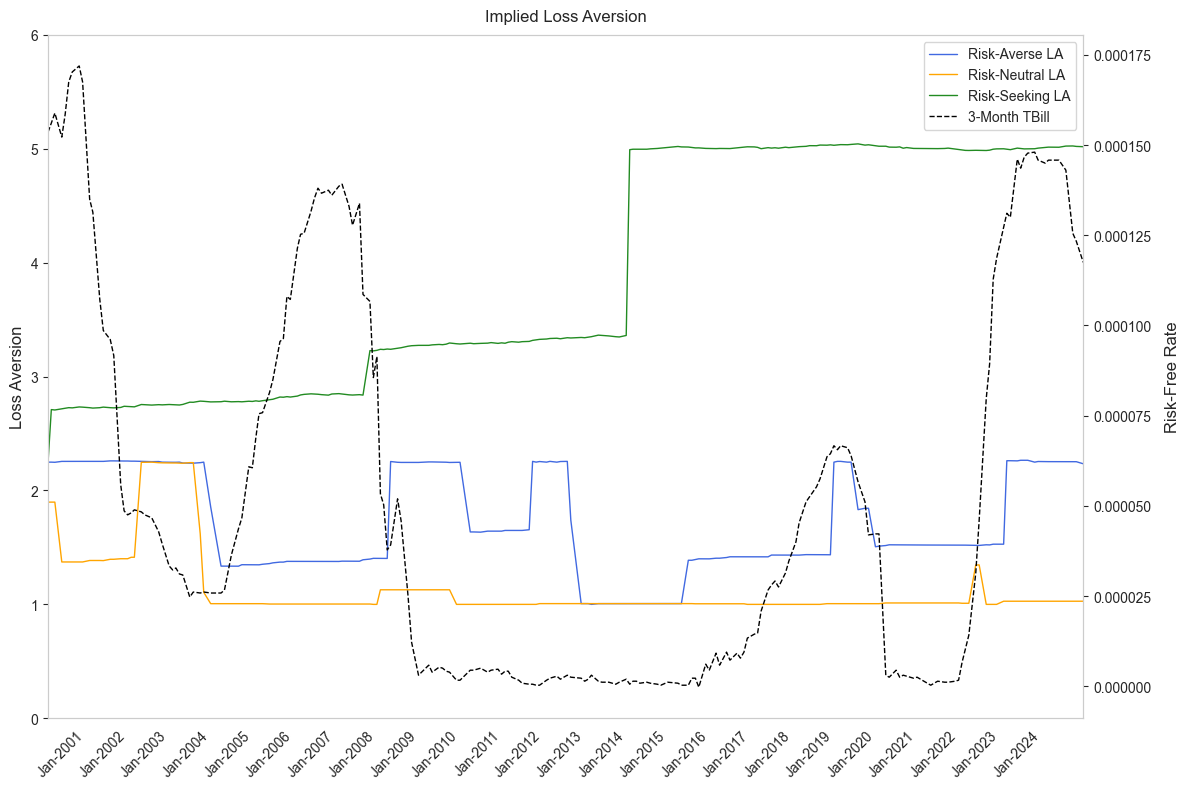

In [ ]:
# ==============================================================================
# 1. GRAPHING IMPLIED LOSS AVERSION FOR EACH INVESTOR
# ==============================================================================

# Set style
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12,8))

# Main axis for S&P 500 and ICE Bonds

ax1.plot(merged_data.index, 
         merged_data['lam_hat_risk_averse'], 
         color='royalblue', lw=1,
         label='Risk-Averse LA')

ax1.plot(merged_data.index, 
         merged_data['lam_hat_risk_neutral'], 
         color='orange', lw=1,
         label='Risk-Neutral LA')

ax1.plot(merged_data.index, 
         merged_data['lam_hat_risk_seeking'], 
         color='forestgreen', lw=1,
         label='Risk-Seeking LA')

ax1.set_ylabel('Loss Aversion', fontsize=12)
ax1.set_ylim(0,6)
ax1.set_xlim(merged_data.index.min(), merged_data.index.max())

ax2 = ax1.twinx()
ax2.plot(merged_data.index, 
         merged_data['3MTB_m'], 
         color='black', lw=1, linestyle='dashed',
         label='3-Month TBill')

ax2.set_ylabel('Risk-Free Rate', fontsize=12, labelpad=10)

ax1.grid(False)      # Turn off grid for main axis
ax2.grid(False)      # Turn off grid for secondary axis

# Format Month ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Implied Loss Aversion', pad=10)
plt.tight_layout()
plt.savefig("implied_loss_aversion_v4.png", dpi=300, bbox_inches="tight")
plt.show()

## Time Series Plots

In [ ]:
display(df_logged_daily)

,log_3MTB_d,log_stock_ret_d,log_bond_ret_d,log_stock_excess_d,log_bond_excess_d
date,,,,,
1999-01-05,0.000121,0.011818,-0.003846,0.011696,-0.003967
1999-01-06,0.000121,0.020922,0.002388,0.020801,0.002267
1999-01-07,0.000120,-0.000800,-0.002694,-0.000920,-0.002815
1999-01-08,0.000121,0.004593,-0.002583,0.004472,-0.002704
1999-01-11,0.000122,-0.004994,-0.001507,-0.005116,-0.001629
...,...,...,...,...,...
2024-12-23,0.000118,0.005617,-0.002809,0.005499,-0.002927
2024-12-24,0.000119,0.010510,0.001102,0.010391,0.000983
2024-12-27,0.000116,-0.010749,-0.002136,-0.010866,-0.002252


In [ ]:
df_logged_daily = df_logged_daily.join(df_clean_daily['ffer_d'], how='left')
display(df_logged_daily)

,log_3MTB_d,log_stock_ret_d,log_bond_ret_d,log_stock_excess_d,log_bond_excess_d,ffer_d
date,,,,,,
1999-01-05,0.000121,0.011818,-0.003846,0.011696,-0.003967,4.54
1999-01-06,0.000121,0.020922,0.002388,0.020801,0.002267,4.23
1999-01-07,0.000120,-0.000800,-0.002694,-0.000920,-0.002815,4.49
1999-01-08,0.000121,0.004593,-0.002583,0.004472,-0.002704,4.74
1999-01-11,0.000122,-0.004994,-0.001507,-0.005116,-0.001629,5.17
...,...,...,...,...,...,...
2024-12-23,0.000118,0.005617,-0.002809,0.005499,-0.002927,4.33
2024-12-24,0.000119,0.010510,0.001102,0.010391,0.000983,4.33
2024-12-27,0.000116,-0.010749,-0.002136,-0.010866,-0.002252,4.33


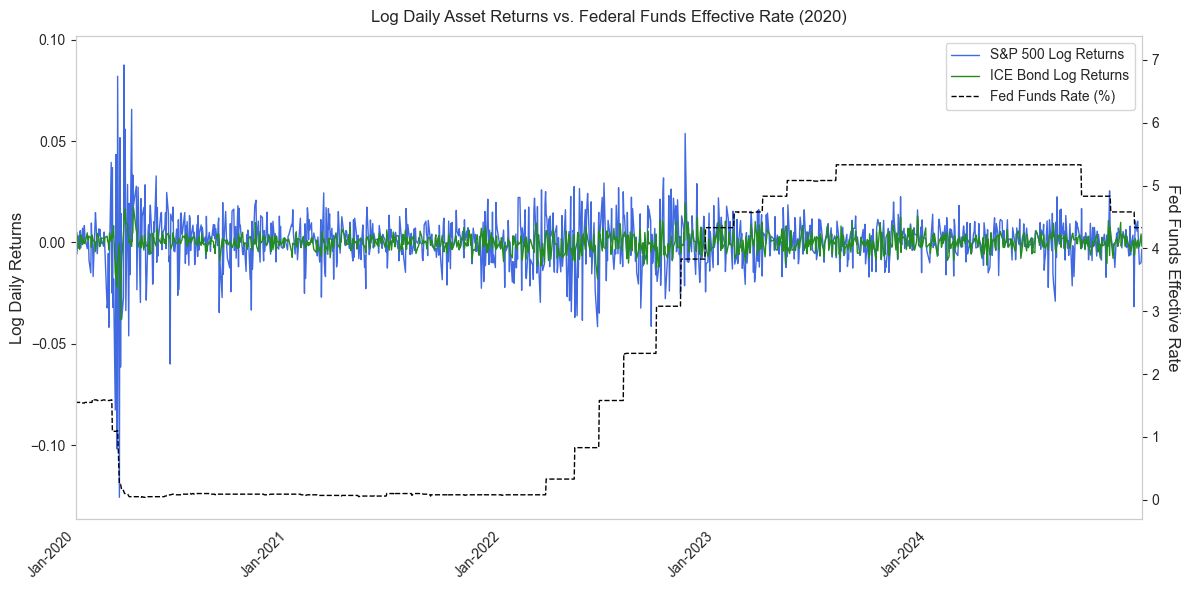

In [ ]:
# PANDEMIC VOLATILITY
# ------------------------------------------------------------------------------------------------------

# Set style
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12,6))

# Main axis for S&P 500 and ICE Bonds

ax1.plot(df_logged_daily.index, 
         df_logged_daily['log_stock_ret_d'], 
         color='royalblue', lw=1,
         label='S&P 500 Log Returns')
ax1.plot(df_logged_daily.index, 
         df_logged_daily['log_bond_ret_d'], 
         color='forestgreen', lw=1,
         label='ICE Bond Log Returns')

ax1.set_ylabel('Log Daily Returns', fontsize=12)

# Second axis for Fed Funds
ax2 = ax1.twinx()
ax2.plot(df_logged_daily.index, 
         df_logged_daily['ffer_d'], 
         color='black', ls='--', lw=1,
         label='Fed Funds Rate (%)')
ax2.set_ylabel('Fed Funds Effective Rate', fontsize=12, rotation=270, labelpad=15)

#ax1.set_xlabel(' ', labelpad=10)                                                                # suppress labels for x-axis

# Limit to the year 2020
start = pd.Timestamp('2020-01-01')
end   = pd.Timestamp('2024-12-31')
ax1.set_xlim(start, end)

ax1.grid(False)                                                                                 # Turn off grid for main axis
ax2.grid(False)                                                                                 # Turn off grid for secondary axis

# Format Month ticks
ax1.xaxis.set_major_locator(mdates.MonthLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Log Daily Asset Returns vs. Federal Funds Effective Rate (2020)', pad=10)
plt.tight_layout()
plt.savefig("2020_logdailyassetreturns-fedfunds_v2.pdf", bbox_inches="tight")
plt.show()

In [ ]:
df_logged_monthly

,log_3MTB_m,log_stock_ret_m,log_bond_ret_m,log_stock_excess_m,log_bond_excess_m
date,,,,,
1999-01-29,0.003610,0.037726,0.010163,0.034116,0.006553
1999-02-26,0.003693,-0.038827,-0.025938,-0.042520,-0.029631
1999-03-31,0.003693,0.037224,0.009048,0.033531,0.005355
1999-04-30,0.003569,0.047925,0.003468,0.044356,-0.000101
1999-05-28,0.003743,-0.020925,-0.014575,-0.024668,-0.018318
...,...,...,...,...,...
2024-08-30,0.004200,0.021343,0.015206,0.017143,0.011007
2024-09-30,0.003926,0.020753,0.017083,0.016827,0.013157
2024-10-31,0.003751,-0.008333,-0.022753,-0.012084,-0.026504


In [ ]:
df_logged_monthly = df_logged_monthly.join(df_clean_monthly['ffer_m'], how='left')
display(df_logged_monthly)

,log_3MTB_m,log_stock_ret_m,log_bond_ret_m,log_stock_excess_m,log_bond_excess_m,ffer_m
date,,,,,,
1999-01-29,0.003610,0.037726,0.010163,0.034116,0.006553,4.79
1999-02-26,0.003693,-0.038827,-0.025938,-0.042520,-0.029631,4.84
1999-03-31,0.003693,0.037224,0.009048,0.033531,0.005355,4.98
1999-04-30,0.003569,0.047925,0.003468,0.044356,-0.000101,5.03
1999-05-28,0.003743,-0.020925,-0.014575,-0.024668,-0.018318,4.61
...,...,...,...,...,...,...
2024-08-30,0.004200,0.021343,0.015206,0.017143,0.011007,5.33
2024-09-30,0.003926,0.020753,0.017083,0.016827,0.013157,4.83
2024-10-31,0.003751,-0.008333,-0.022753,-0.012084,-0.026504,4.83


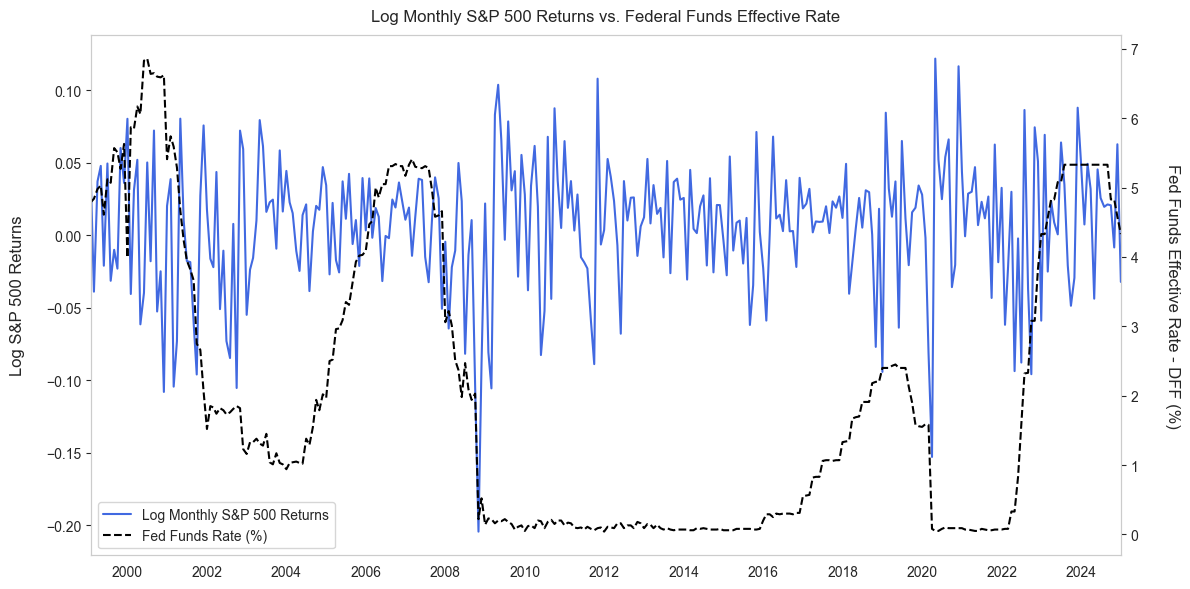

In [ ]:
# PLOT S&P 500 AND FED FUNDS RATE
# ------------------------------------------------------------------------------------------------------

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Main axis for S&P 500
ax1 = plt.gca()
sns.lineplot(data=df_logged_monthly, x='date', y='log_stock_ret_m', 
             color='royalblue', label='Log Monthly S&P 500 Returns', ax=ax1, legend=False)
#ax1.set_ylim(bottom = df_logged_monthly['sp500_log_return_m'].min(), top = df_logged_monthly['sp500_log_return_m'].max())

# Second axis for Fed Funds
ax2 = ax1.twinx()
sns.lineplot(data=df_logged_monthly, x='date', y='ffer_m', 
             color='black', linestyle='--', label='Fed Funds Rate (%)', ax=ax2, legend=False)
#ax2.set_ylim(bottom=-0.1, top=8)

# Format X-Axis 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))               # show year only
ax1.xaxis.set_major_locator(mdates.YearLocator(2))                      # frequency of years is every 2 years

# Format Y-Axis
ax1.set_ylabel('Log S&P 500 Returns', fontsize=12, labelpad=15)         # left y-axis label for log asset returns
ax2.set_ylabel('Fed Funds Effective Rate - DFF (%)',                    # right axis for federal funds effective rate (DFF)
               fontsize=12, rotation=270, labelpad=30)                  
ax1.set_xlabel('')                                                      # suppress labels for x-axis
ax1.grid(False)                                                         # Turn off grid for main axis
ax2.grid(False)                                                         # Turn off grid for secondary axis

# X-axis limits
ax1.set_xlim(df_logged_monthly.index.min(), df_logged_monthly.index.max())
ax2.set_xlim(df_logged_monthly.index.min(), df_logged_monthly.index.max())

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.title('Log Monthly S&P 500 Returns vs. Federal Funds Effective Rate', pad=10)
plt.tight_layout()
plt.savefig("log_sp500_returns_vs_fedfunds_v2.pdf", bbox_inches="tight")
plt.show()

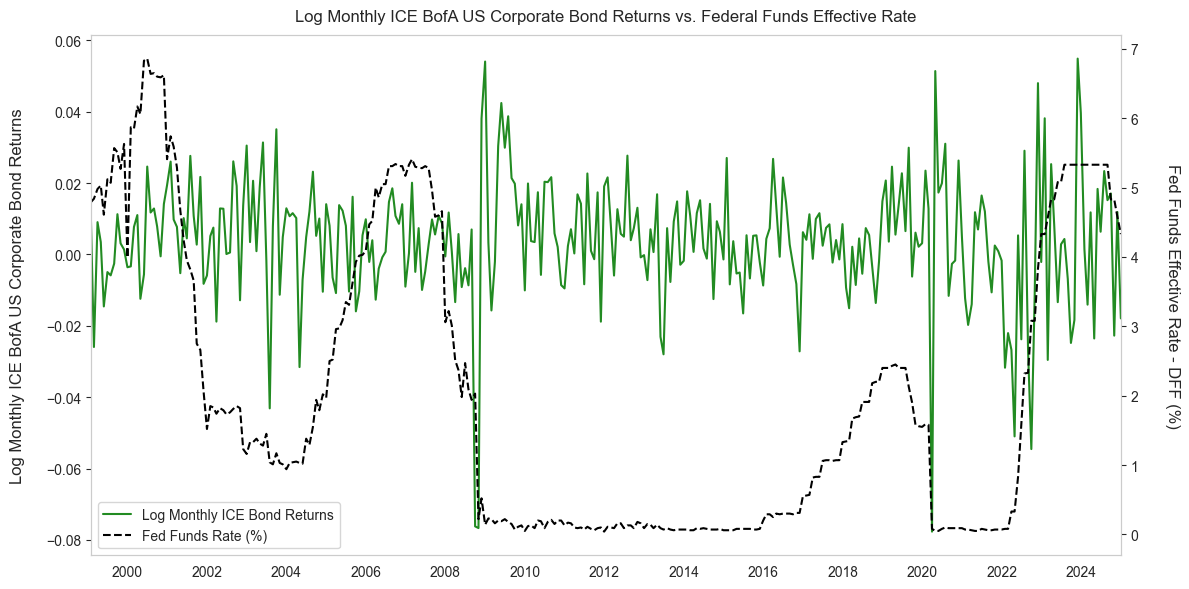

In [ ]:
# PLOT ICE BOND INDEX AND FED FUNDS RATE
# ------------------------------------------------------------------------------------------------------

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Main axis for ICE Bonds
ax1 = plt.gca()
sns.lineplot(data=df_logged_monthly, x='date', y='log_bond_ret_m', 
             color='forestgreen', label='Log Monthly ICE Bond Returns', ax=ax1, legend=False)
#ax1.set_ylim(bottom=-0.2, top=0.2)

# Second axis for Fed Funds
ax2 = ax1.twinx()
sns.lineplot(data=df_logged_monthly, x='date', y='ffer_m', 
             color='black', linestyle='--', label='Fed Funds Rate (%)', ax=ax2, legend=False)
#ax1.set_ylim(bottom = df_logged_monthly['ice_log_return_m'].min(), top = df_logged_monthly['ice_log_return_m'].max())

# Format X-Axis 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))               # show year only
ax1.xaxis.set_major_locator(mdates.YearLocator(2))                      # frequency of years is every 2 years

# Format Y-Axis
ax1.set_ylabel('Log Monthly ICE BofA US Corporate Bond Returns',                # left y-axis label for log asset returns
               fontsize=12, labelpad=15)           
ax2.set_ylabel('Fed Funds Effective Rate - DFF (%)',                    # right axis for federal funds effective rate (DFF)
               fontsize=12, rotation=270, labelpad=30)                  
ax1.set_xlabel('')                                                      # suppress labels for x-axis
ax1.grid(False)                                                         # Turn off grid for main axis
ax2.grid(False)                                                         # Turn off grid for secondary axis

# X-axis limits
ax1.set_xlim(df_logged_monthly.index.min(), df_logged_monthly.index.max())
ax2.set_xlim(df_logged_monthly.index.min(), df_logged_monthly.index.max())

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.title('Log Monthly ICE BofA US Corporate Bond Returns vs. Federal Funds Effective Rate', pad=10)
plt.tight_layout()
plt.savefig("log_icebond_returns_vs_fedfunds_v2.pdf", bbox_inches="tight")
plt.show()